<h1><center>Predicting Malaria Burden in Uganda Through Socioeconomic Indicators and Housing Characteristics</center></h1>

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns

# Statistical Analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample

# Utilities
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit

# Import and merge data

In [2]:
# Load the data
df_households = pd.read_csv('data/LLINE-UP_rct_Households.txt', delimiter='\t', low_memory=False)
df_participants = pd.read_csv('data/LLINE-UP_rct_Participants.txt', delimiter='\t', low_memory=False)
df_samples = pd.read_csv('data/LLINE-UP_rct_Samples.txt', delimiter='\t')

In [3]:
# Merge participants with samples
df_merged = df_participants.merge(
    df_samples.drop(columns=["Household_Id", "Community_Id"], errors="ignore"),
    on="Participant_Id",
    how="left"
)

# Merge with households
df_merged = df_merged.merge(df_households, on="Household_Id", how="left")

# Drop all ID columns
df_merged = df_merged.drop(columns=["Participant_Id", "Sample_Id", "Community_Id", "Household_Id"], 
                           errors="ignore")

In [4]:
# Drop these columns as they are not needed - they do not contain
# information about SES or household characteristics
columns_to_drop = [
    'Participant_Id', 'Sample_Id', 'Community_Id', 'Household_Id', 'Community_Id_x', 'Community_Id_y',
    'Acres categorization [EUPATH_0020221]', 'Age group [EUPATH_0010367]', 'Arthropods surveyed [EUPATH_0044118]',
    'Blood smear barcode [CLINEPIDB_00662]', 'Bloodfed Anopheles funestus count [EUPATH_0000192]',
    'Bloodfed Anopheles gambiae count [EUPATH_0000193]', 
    'Community health worker has malaria medication [EUPATH_0020229]',
    'Community health worker present [EUPATH_0020230]', 'Collection date [EUPATH_0020003]',
    'Eligible for clinical survey [EUPATH_0044101]', 'Enumeration area ID [EUPATH_0044123]', 
    'Febrile [EUPATH_0000097]', 'Female Anopheles count [EUPATH_0000135]', 
    'Female Anopheles funestus count [EUPATH_0000136]', 'Female Anopheles gambiae count [EUPATH_0000137]', 
    'Female non-Anopheline count [EUPATH_0044116]', 'Filter paper barcode [CLINEPIDB_00661]', 
    'Gravid Anopheles funestus count [EUPATH_0000197]', 'Gravid Anopheles gambiae count [EUPATH_0000198]', 
    'Health facility distance categorization [EUPATH_0020214]', 'Hemoglobin (g/dL) [CMO_0000026]', 
    'Household bednets [EUPATH_0020232]', 'Household data collection date [EUPATH_0021085]',
    'Household ITNs [EUPATH_0044136]', 'Household study timepoint [EUPATH_0044122]', 
    'ITN bednet count categorization [EUPATH_0044126]', 'Male Anopheles count [EUPATH_0025031]', 
    'Male Anopheles funestus count [EUPATH_0044102]', 'Male Anopheles gambiae count [EUPATH_0044104]',
    'Male non-Anopheline count [EUPATH_0044117]', 'Meals per day categorization [EUPATH_0020237]', 
    'Meat meals per week categorization [EUPATH_0020238]', 'Bednet count categorization [EUPATH_0020226]', 
    'Non-UCC bednets [EUPATH_0044141]', 'Observation date [EUPATH_0004991]',
    '1 ITN per 2 people [EUPATH_0044135]', 'One bednet per 2 people [EUPATH_0020219]', 
    'Other female Anopheles species count [EUPATH_0000200]', 'Other male Anopheles species count [EUPATH_0044106]', 
    'Persons 5-15 years sleeping in dwelling count [EUPATH_0044164]',
    'Persons 5-15 years sleeping under bednet count [EUPATH_0044158]', 
    'Persons <5 years sleeping in dwelling count [EUPATH_0044162]',
    'Persons <5 years sleeping under bednet count [EUPATH_0044156]', 
    'Persons unknown age sleeping in dwelling count [EUPATH_0044165]',
    'Persons age unknown sleeping under bednet count [EUPATH_0044159]', 
    'Plasmodium asexual stages by microscopy result (/uL) [EUPATH_0000092]',
    'Plasmodium falciparum gametocytes by microscopy [EUPATH_0027010]', 
    'Reason UCC LLIN not received [EUPATH_0044145]', 'Relationship to household head [EUPATH_0000376]', 
    'Semigravid Anopheles funestus count [EUPATH_0044103]', 'Semigravid Anopheles gambiae count [EUPATH_0044105]', 
    'Sleeping rooms used last night count [EUPATH_0044119]', 'Study timepoint [OBI_0001508]', 
    'UCC LLIN type [EUPATH_0044148]', 'UCC LLIN wave [EUPATH_0044168]',
    'Unfed Anopheles funestus count [EUPATH_0000204]', 'Unfed Anopheles gambiae count [EUPATH_0000205]', 
    'Anemia (hemoglobin <10 g/dL) [EUPATH_0020209]', 'Anemia (hemoglobin <11 g/dL) [EUPATH_0011161]',
    'Anemia (hemoglobin <8 g/dL) [EUPATH_0044112]', 'Age <2 years [EUPATH_0044139]', 
    'Household wealth index, categorical [EUPATH_0000143]', 'Household wealth index, numerical [EUPATH_0000014]', 
    'Persons sleeping in dwelling count [EUPATH_0000714]', 'Sleeping places count [EUPATH_0000201]', 
    'Persons <5 years living in house [EUPATH_0044161]', 
    'Persons >15 years sleeping in dwelling count [EUPATH_0044163]', 
    'Persons >15 years sleeping under bednet count [EUPATH_0044157]', 
    'Persons sleeping under bednet count [EUPATH_0044155]', 
    'Plasmodium asexual stages, by microscopy result (/uL) [EUPATH_0000092]', 
    'Plasmodium falciparum gametocytes, by microscopy [EUPATH_0027010]', 
    'Relationship to household head categorization [EUPATH_0044138]', 'Remaining UCC LLIN count [EUPATH_0044144]', 
    'Time doors and windows closed [EUPATH_0044132]', 
    'Time since last UCC LLIN distribution (months) [EUPATH_0044166]', 
    'Time since last UCC LLIN distribution categorization [EUPATH_0044167]', 
    'UCC LLIN instructions received [EUPATH_0044143]', 'Hemoglobin measurement performed [EUPATH_0027005]',
    'Reason refused IRS [EUPATH_0044134]', 'Screened air bricks [EUPATH_0044115]', 
    'Screened external doors [EUPATH_0044114]'    
]

# Drop the columns
df_merged = df_merged.drop(columns=columns_to_drop, errors="ignore")

In [5]:
# Rename the long field names to shorter, more descriptive names
# Dictionary containing original names and new names
rename_dict = {
    "Acres [EUPATH_0000026]": "acres",
    "Age (years) [OBI_0001169]": "age_years",
    "Air bricks [EUPATH_0000018]": "air_bricks",
    "Bank account [EUPATH_0000167]": "bank_account",
    "Bednet last night [EUPATH_0025013]": "bednet_used_last_night",
    "Blood smear performed [EUPATH_0041029]": "blood_smear_performed",
    "Burn to keep mosquitoes away [EUPATH_0044128]": "burn_mosquito_repel",
    "Consent for lab testing [EUPATH_0044111]": "consent_lab_testing",
    "Cooking fuel [EUPATH_0000023]": "cooking_fuel_type",
    "Doors and windows closed [EUPATH_0044129]": "doors_windows_closed",
    "Dwelling type [ENVO_01000744]": "dwelling_type",
    "Eaves [ENVO_01000825]": "eave_type",
    "Floor material [EUPATH_0000006]": "floor_type",
    "Food problems per week [EUPATH_0000029]": "food_insecurity_weekly",
    "Bed [ENVO_00000501]": "has_bed",
    "Bicycle [ENVO_01000614]": "has_bicycle",
    "Car or truck [EUPATH_0000171]": "has_car_or_truck",
    "Cassette player [ENVO_01000578]": "has_cassette_player",
    "Ceiling [EUPATH_0044113]": "has_ceiling",
    "Chair [ENVO_01000586]": "has_chair",
    "Clock [ENVO_01000596]": "has_clock",
    "Cupboard [ENVO_01000595]": "has_cupboard",
    "Desktop computer [EUPATH_0044107]": "has_desktop_computer",
    "Electricity [EUPATH_0021084]": "has_electricity",
    "Refrigerator [ENVO_01000583]": "has_fridge",
    "Internet device [EUPATH_0020205]": "has_internet_device",
    "Laptop computer [EUPATH_0044108]": "has_laptop",
    "Mobile phone [ENVO_01000581]": "has_mobile_phone",
    "Boat with a motor [EUPATH_0000179]": "has_motor_boat",
    "Motorcycle or scooter [ENVO_01000615]": "has_motorcycle",
    "Boat without a motor [EUPATH_0000170]": "has_non_motor_boat",
    "Radio [ENVO_01000577]": "has_radio",
    "Smartphone [EUPATH_0044109]": "has_smartphone",
    "Sofa [ENVO_01000588]": "has_sofa",
    "Table [ENVO_01000584]": "has_table",
    "Tablet computer [EUPATH_0044110]": "has_tablet",
    "Television [ENVO_01000579]": "has_tv",
    "Watch [EUPATH_0000186]": "has_watch",
    "Windows [EUPATH_0025050]": "has_windows",
    "Health facility distance (km) [EUPATH_0020213]": "health_facility_distance_km",
    "Household head age categorization (years) [EUPATH_0044151]": "hh_head_age_category",
    "Household head's sex [EUPATH_0044152]": "hh_head_sex",
    "Household wealth index categorical [EUPATH_0000143]": "hh_wealth_category",
    "Household wealth index numerical [EUPATH_0000014]": "hh_wealth_score",
    "Human waste facilities [EUPATH_0000335]": "human_waste_facilities",
    "Insecticide last night [EUPATH_0044130]": "insecticide_used_last_night",
    "Internet device type [EUPATH_0044140]": "internet_device_type",
    "Asked permission for IRS in last 12 months [EUPATH_0020224]": "irs_permission_last_12m",
    "ITN bednet count [EUPATH_0041014]": "itn_count",
    "ITN last night [EUPATH_0000216]": "itn_used_last_night",
    "ITNs per person count [EUPATH_0044137]": "itns_per_person",
    "Lighting source [OBI_0400065]": "lighting_source",
    "Market distance (km) [EUPATH_0020215]": "market_distance_km",
    "Material burned [EUPATH_0044127]": "material_burned",
    "Meals per day [EUPATH_0000027]": "meals_per_day",
    "Mean people per room [EUPATH_0011604]": "mean_people_per_room",
    "Meat meals per week [EUPATH_0000028]": "meat_meals_per_week",
    "Bednet count [EUPATH_0020225]": "net_count",
    "Bednets per person count [EUPATH_0020227]": "nets_per_person",
    "Crowding [EUPATH_0044160]": "people_per_room",
    "Plasmodium by RDT [EUPATH_0024217]": "plasmodium_detected_rdt",
    "Plasmodium by thick smear microscopy [EUPATH_0024314]": "plasmodium_detected_thick_smear",
    "RDT performed [EUPATH_0027004]": "rdt_performed",
    "Sleeping rooms in dwelling count [EUPATH_0000025]": "sleeping_rooms_count",
    "Sprayed in the last 12 months [EUPATH_0000441]": "sprayed_last_12_months",
    "UCC LLIN count [EUPATH_0044146]": "ucc_itn_count",
    "UCC LLIN received [EUPATH_0044142]": "ucc_itn_received",
    "Wall material [EUPATH_0000009]": "wall_material",
    "Drinking water source [ENVO_00003064]": "water_source",
    "Windows covered [EUPATH_0020212]": "windows_covered",
    "Plasmodium, by RDT [EUPATH_0024217]": "plasmodium_detected_rdt",
    "Plasmodium, by thick smear microscopy [EUPATH_0024314]": "plasmodium_detected_thick_smear",
    "Persons living in house count [EUPATH_0000019]": "persons_living_house",
    "Sex [PATO_0000047]": "sex",
    "Transit to health facility [EUPATH_0020217]": "transit_to_health_facility",
    "Roof material [EUPATH_0000003]": "roof_material",
    "Screened air bricks [EUPATH_0044115]": "screened_air_bricks",
    "Screened external doors [EUPATH_0044114]": "screened_external_doors",
    "Sprayed in the last 12 months categorization [EUPATH_0020250]": "sprayed_last_12_months_category",
    "Time since last IRS (months) [EUPATH_0044131]": "time_since_last_irs_months"
}

# Rename the field names using the dictionary
df_merged = df_merged.rename(columns=rename_dict)


# Data cleaning

##### Only keep records where participant consented to lab testing

In [6]:
# Since we are only interested in participants who had lab testing done,
# keep only rows where 'consent_lab_testing' == 'Yes'
df_merged = df_merged[df_merged['consent_lab_testing'] == 'Yes']
# and drop the column since it is not needed any more
df_merged = df_merged.drop(columns=['consent_lab_testing'])

# Keep records where either blood_smear_performed OR rdt_performed is 'Yes'
# This will help create the target variable - malaria
df_merged = df_merged[
    (df_merged['blood_smear_performed'] == 'Yes') |
    (df_merged['rdt_performed'] == 'Yes')
]

# Drop 'blood_smear_performed' and 'rdt_performed' columns
df_merged = df_merged.drop(columns=['blood_smear_performed', 'rdt_performed'], errors='ignore')

# Create 'malaria' target variable: 1 if detected by either test, else 0
# The 
df_merged['malaria'] = (
    (df_merged['plasmodium_detected_rdt'] == 'Yes') |
    (df_merged['plasmodium_detected_thick_smear'] == 'Yes')
).astype(int)

# Drop original detection columns
df_merged = df_merged.drop(columns=['plasmodium_detected_rdt', 'plasmodium_detected_thick_smear'], 
                           errors='ignore')

##### Clean all the Yes/No variables

In [7]:
# Define the yes/no variables
yes_no_vars = [
    'people_per_room', 'windows_covered', 'has_bicycle', 'has_cassette_player', 'has_chair', 'has_clock',
    'has_cupboard', 'has_non_motor_boat', 'has_motor_boat', 'has_watch', 'has_motorcycle', 'has_fridge',
    'has_table', 'has_tv', 'bednet_used_last_night', 'itn_used_last_night', 'has_desktop_computer',
    'has_laptop', 'has_smartphone', 'sprayed_last_12_months', 'has_tablet', 'has_electricity', 'has_radio',
    'has_windows', 'has_mobile_phone', 'burn_mosquito_repel', 'insecticide_used_last_night', 'bank_account',
    'has_car_or_truck', 'has_sofa', 'has_bed', 'irs_permission_last_12m', 'ucc_itn_received',
    'has_internet_device'
]

In [8]:
def compute_yes_no_counts(df, yes_no_vars):
    """
    Aggregates value counts for each variable in yes_no_vars.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    yes_no_vars (list): List of column names to compute category counts for.

    Returns:
    DataFrame: A Pandas DataFrame with aggregated and pivoted counts.
    """
    results = []

    for col in yes_no_vars:
        if col in df.columns:
            counts = df[col].value_counts(dropna=False).rename_axis("category").reset_index(name="count")
            counts["variable"] = col
            results.append(counts)

    if results:
        counts_df = pd.concat(results, ignore_index=True)
        pivot_df = counts_df.pivot_table(index="variable", columns="category", values="count", fill_value=0)
        pivot_df.reset_index(inplace=True)
        return pivot_df
    else:
        return pd.DataFrame()  # Empty DataFrame if nothing matched


In [9]:
# show the counts of different responses and counts for numeric variables
summary_df = compute_yes_no_counts(df_merged, yes_no_vars)
summary_df

category,variable,Don't know,Missing,No,Not applicable,Refused to answer,Yes
0,bank_account,19.0,0.0,32250.0,0.0,3.0,6477.0
1,bednet_used_last_night,0.0,0.0,11951.0,0.0,0.0,26798.0
2,burn_mosquito_repel,2.0,20.0,7718.0,0.0,0.0,222.0
3,has_bed,1.0,0.0,3824.0,0.0,1.0,34923.0
4,has_bicycle,0.0,0.0,27148.0,0.0,1.0,11600.0
5,has_car_or_truck,1.0,0.0,37916.0,0.0,1.0,831.0
6,has_cassette_player,0.0,0.0,35598.0,0.0,1.0,3150.0
7,has_chair,0.0,0.0,4124.0,0.0,1.0,34624.0
8,has_clock,0.0,0.0,34670.0,0.0,1.0,4078.0
9,has_cupboard,0.0,0.0,30896.0,0.0,1.0,7852.0


This is the criteria that was use to decide which variables to keep:

**Missing data thresholds:**
- Variables with greater than 10% missing values or if one category accounted for more than 80% of observations were dropped.
- Rows where the variable has less than 5% missing data were dropped.

In [10]:
# Drop columns with missing data or highly skewed categories
cols_to_drop = [
    'people_per_room', 'has_desktop_computer', 'has_laptop', 'sprayed_last_12_months', 'has_tablet',
    'burn_mosquito_repel', 'has_windows', 'insecticide_used_last_night', 'ucc_itn_received', 
    'has_non_motor_boat', 'has_motor_boat', 'has_fridge', 'has_car_or_truck', 'irs_permission_last_12m', 
    'has_smartphone', 'itn_used_last_night'
]
df_merged = df_merged.drop(columns=cols_to_drop, errors="ignore")

# Drop records where windows_covered == 'Not applicable'
df_merged = df_merged[df_merged["windows_covered"] != "Not applicable"]

# Drop records where windows_covered or has_watch are null
df_merged = df_merged.dropna(subset=["windows_covered", "has_watch"])

# Drop rows where any of the specified columns contain "Refused to answer"
vars_to_clean_refused = [
    'has_bicycle', 'has_cassette_player', 'has_chair', 'has_clock', 'has_cupboard',
    'has_watch', 'has_motorcycle', 'has_table', 'has_tv', 'bank_account', 'has_sofa',
    'has_bed', 'has_internet_device'
]
existing_refused = [col for col in vars_to_clean_refused if col in df_merged.columns]
df_merged = df_merged[~df_merged[existing_refused].isin(["Refused to answer"]).any(axis=1)]

# Drop rows where any of the specified columns contain "Don't know"
vars_to_clean_dontknow = ['bank_account', 'has_sofa', 'has_bed', 'has_internet_device']
existing_dontknow = [col for col in vars_to_clean_dontknow if col in df_merged.columns]
df_merged = df_merged[~df_merged[existing_dontknow].isin(["Don't know"]).any(axis=1)]

In [11]:
# show the new counts 
summary_df = compute_yes_no_counts(df_merged, yes_no_vars)
summary_df

category,variable,No,Yes
0,bank_account,24687.0,6070.0
1,bednet_used_last_night,9232.0,21525.0
2,has_bed,1763.0,28994.0
3,has_bicycle,21748.0,9009.0
4,has_cassette_player,27823.0,2934.0
5,has_chair,2723.0,28034.0
6,has_clock,26850.0,3907.0
7,has_cupboard,23260.0,7497.0
8,has_electricity,25697.0,5060.0
9,has_internet_device,27394.0,3363.0


In [12]:
# Update the list with the new Yes/No columns 
yes_no_vars = [
    'windows_covered', 'has_bicycle', 'has_cassette_player', 'has_chair', 'has_clock', 'has_cupboard',
    'has_watch', 'has_motorcycle', 'has_table', 'has_tv', 'bednet_used_last_night', 'has_electricity',
    'has_radio', 'has_mobile_phone', 'bank_account', 'has_sofa', 'has_bed', 'has_internet_device'
]

# Convert 'yes' to 1 and 'no' to 0
df_merged[yes_no_vars] = df_merged[yes_no_vars].apply(
    lambda col: col.map({'Yes': 1, 'No': 0})
)

##### Update the sex field to be numeric

In [13]:
# Count values in the two sex-related columns
print(df_merged["sex"].value_counts(dropna=False))
print(df_merged["hh_head_sex"].value_counts(dropna=False))

sex
Female    15835
Male      14922
Name: count, dtype: int64
hh_head_sex
NaN       23975
Male       5426
Female     1356
Name: count, dtype: int64


In [14]:
# Drop 'hh_head_sex' since it has mostly NULLs
df_merged = df_merged.drop(columns=["hh_head_sex"], errors="ignore")

# Convert 'sex' values: Male = 1, Female = 2, everything else = NaN
df_merged["sex"] = df_merged["sex"].map({"Male": 1, "Female": 2})

# Show counts of each value, including missing values
print(df_merged["sex"].value_counts(dropna=False))

sex
2    15835
1    14922
Name: count, dtype: int64


##### Clean all the Categorical variables

In [15]:
categorical_vars = [
    'hh_head_age_category', 'air_bricks', 'cooking_fuel_type', 'water_source', 'dwelling_type', 
    'eave_type', 'floor_type', 'food_insecurity_weekly', 'human_waste_facilities', 
    'internet_device_type', 'lighting_source', 'material_burned', 'roof_material', 
    'sprayed_last_12_months_category', 'transit_to_health_facility', 'wall_material', 
    'doors_windows_closed', 'has_ceiling'
]

In [16]:
def compute_category_dominance(df, categorical_vars):
    """
    Compute the top category percentage and NaN percentage for categorical variables.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    categorical_vars (list): List of categorical column names.

    Returns:
    DataFrame: A Pandas DataFrame with top category dominance and NaN percentages.
    """
    dominance_data = []

    total_count = len(df)

    for col in categorical_vars:
        if col in df.columns:
            # Count NaNs
            nan_count = df[col].isna().sum()
            nan_percentage = (nan_count / total_count) * 100

            # Value counts (excluding NaN)
            value_counts = df[col].value_counts(normalize=True) * 100

            if not value_counts.empty:
                top_category = value_counts.idxmax()
                top_percentage = value_counts.max()
            else:
                top_category = np.nan
                top_percentage = 0.0

            dominance_data.append({
                "Variable": col,
                "Top Category": top_category,
                "Percentage": top_percentage,
                "NaN Percentage": nan_percentage
            })

    result_df = pd.DataFrame(dominance_data)

    # Sort by NaN Percentage descending
    result_df.sort_values(by="NaN Percentage", ascending=False, inplace=True)

    return result_df

In [17]:
dominance_df = compute_category_dominance(df_merged, categorical_vars)
dominance_df

,Variable,Top Category,Percentage,NaN Percentage
9,internet_device_type,Smartphone,92.358014,89.065904
11,material_burned,Did not burn anything,96.863190,82.794161
1,air_bricks,"Yes, over all windows",58.635864,79.312027
16,doors_windows_closed,Yes,77.510608,79.312027
17,has_ceiling,No or only over some rooms,73.974540,79.312027
4,dwelling_type,Traditional,68.372162,77.949735
0,hh_head_age_category,30-39 years,32.232380,77.949735
5,eave_type,Closed,70.195403,0.000000
6,floor_type,Cement or concrete,36.388464,0.000000
7,food_insecurity_weekly,Sometimes,43.560815,0.000000


This is the criteria that was use to decide which variables to keep:

- **Missing data threshold**: Variables with greater than 25% missing values were dropped.

- **Dominance threshold**: Variables in which one category accounted for more than 80% of observations were dropped.

In [18]:
# Drop the columns that have a dominat category or
# have mostly NaN values

# List of categories to drop
categories_to_drop = [
    'internet_device_type', 'material_burned', 'doors_windows_closed', 'air_bricks', 'has_ceiling',
    'hh_head_age_category', 'dwelling_type', 'roof_material', 'sprayed_last_12_months_category',
    'cooking_fuel_type'
]
df_merged = df_merged.drop(columns=categories_to_drop, errors="ignore")

In [19]:
# Updated list of categorical variables
categorical_vars = [
    'water_source', 'eave_type', 'floor_type', 'food_insecurity_weekly', 'human_waste_facilities',
    'lighting_source', 'transit_to_health_facility', 'wall_material'
]

# Get the updated information on each categorical vaiable
# to ensure the data looks good
dominance_df = compute_category_dominance(df_merged, categorical_vars)
dominance_df

,Variable,Top Category,Percentage,NaN Percentage
0,water_source,Borehole,27.844068,0.0
1,eave_type,Closed,70.195403,0.0
2,floor_type,Cement or concrete,36.388464,0.0
3,food_insecurity_weekly,Sometimes,43.560815,0.0
4,human_waste_facilities,Covered pit latrine without slab,38.820431,0.0
5,lighting_source,Solar,38.862698,0.0
6,transit_to_health_facility,Walking,57.239003,0.0
7,wall_material,Mud and poles,43.219430,0.0


##### Perform one-hot-encoding on the categorical variables

In [20]:
# One-hot encode and drop original categorical columns
df_merged = pd.get_dummies(
    df_merged,
    columns=categorical_vars,
    prefix=[col + "_onehot" for col in categorical_vars],
    dummy_na=False
)

# Keeping both eave_type_onehot_Open and eave_type_onehot_Closed causes perfect 
# multicollinearity (i.e. one column is exactly the inverse of the other).
df_merged = df_merged.drop(columns=["eave_type_onehot_Closed"])

# Convert all boolean columns to integer (int8) in-place for memory efficiency
bool_cols = df_merged.select_dtypes(include='bool').columns
df_merged[bool_cols] = df_merged[bool_cols].astype('int8')

# Confirm data types after conversion
df_merged.dtypes.value_counts()

int8       76
int64      22
float64    12
int32       1
Name: count, dtype: int64

In [21]:
df_merged.head()

,age_years,bednet_used_last_night,sex,acres,bank_account,has_bed,net_count,nets_per_person,has_bicycle,has_cassette_player,...,wall_material_onehot_Mud and poles,wall_material_onehot_Mud and stone,"wall_material_onehot_Mud, poles, and cement","wall_material_onehot_Mud, poles, and plaster",wall_material_onehot_Stone,"wall_material_onehot_Stone, plaster, and cement",wall_material_onehot_Thatched or straw,wall_material_onehot_Timber,wall_material_onehot_Un-burned bricks,wall_material_onehot_Un-burned bricks with plaster or cement
7,9.0,1,2,3.0,0,1,3,0.3,1,0,...,1,0,0,0,0,0,0,0,0,0
8,7.0,1,2,3.0,0,1,3,0.3,1,0,...,1,0,0,0,0,0,0,0,0,0
9,5.0,1,2,3.0,0,1,3,0.3,1,0,...,1,0,0,0,0,0,0,0,0,0
12,6.0,0,1,1.0,0,1,0,0.0,1,0,...,1,0,0,0,0,0,0,0,0,0
20,7.0,0,2,2.0,0,1,0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


##### Clean the Numeric variables

In [22]:
numeric_vars = [
    'age_years', 'acres', 'net_count', 'nets_per_person', 'health_facility_distance_km', 
    'itn_count', 'itns_per_person', 'market_distance_km', 'meals_per_day', 'mean_people_per_room',
    'meat_meals_per_week', 'persons_living_house', 'sleeping_rooms_count', 'time_since_last_irs_months', 
    'ucc_itn_count'
]

In [23]:
def compute_missing_percentages(df, numeric_vars):
    """
    Compute the percentage of missing values for each numeric variable and sort in descending order.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    numeric_vars (list): List of numeric column names.

    Returns:
    DataFrame: A Pandas DataFrame with missing value percentages sorted in descending order.
    """
    total_count = len(df)
    data = {
        "Variable": [],
        "Missing Percentage": []
    }

    for col in numeric_vars:
        if col in df.columns:
            missing_pct = df[col].isna().sum() / total_count * 100
            data["Variable"].append(col)
            data["Missing Percentage"].append(missing_pct)

    result_df = pd.DataFrame(data)
    result_df = result_df.sort_values(by="Missing Percentage", ascending=False)

    return result_df

In [24]:
missing_report = compute_missing_percentages(df_merged, numeric_vars)
missing_report

,Variable,Missing Percentage
13,time_since_last_irs_months,99.795169
9,mean_people_per_room,77.952986
14,ucc_itn_count,26.940209
1,acres,0.594987
7,market_distance_km,0.087785
4,health_facility_distance_km,0.084534
10,meat_meals_per_week,0.032513
8,meals_per_day,0.009754
12,sleeping_rooms_count,0.006503
0,age_years,0.000000


This is the criteria that was use to decide which variables to keep:

**Missing data thresholds:**
- Variables with greater than 25% missing values were dropped.
- Rows where the variable has less than 1% missing data were dropped

In [25]:
# Drop columns with greater than 25% missing values
columns_to_drop = ['time_since_last_irs_months', 'mean_people_per_room', 'ucc_itn_count']
df_merged = df_merged.drop(columns=columns_to_drop, errors="ignore")

# Drop rows where any of the specified columns have missing values
cols_to_check = ['meals_per_day', 'meat_meals_per_week', 'sleeping_rooms_count',
    'acres', 'market_distance_km', 'health_facility_distance_km'
]
df_merged = df_merged.dropna(subset=cols_to_check)

In [26]:
# Update the list of numeric variables
numeric_vars = [
    'age_years', 'acres', 'net_count', 'nets_per_person', 'health_facility_distance_km', 'itn_count',
    'itns_per_person', 'market_distance_km', 'meals_per_day', 'meat_meals_per_week', 
    'persons_living_house', 'sleeping_rooms_count'
]

missing_report = compute_missing_percentages(df_merged, numeric_vars)
missing_report

,Variable,Missing Percentage
0,age_years,0.0
1,acres,0.0
2,net_count,0.0
3,nets_per_person,0.0
4,health_facility_distance_km,0.0
5,itn_count,0.0
6,itns_per_person,0.0
7,market_distance_km,0.0
8,meals_per_day,0.0
9,meat_meals_per_week,0.0


##### Check for outliers

In [27]:
def plot_numeric_boxplots(df, numeric_vars):
    """
    Plots a grid of boxplots for numeric variables.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    numeric_vars (list): List of numeric column names to plot.
    """
    n_cols = 3
    n_rows = int(np.ceil(len(numeric_vars) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_vars):
        if col in df.columns:
            box = axes[i].boxplot(df[col].dropna(), vert=False, patch_artist=True)

            for patch in box['boxes']:
                patch.set_facecolor('skyblue')
                patch.set_alpha(0.8)

            plt.setp(box['medians'], color='darkred', linewidth=1.5)
            axes[i].set_title(f'Boxplot of {col}')
            axes[i].set_xlabel(col)
            axes[i].grid(True, linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Boxplots of Numeric Variables', y=1.02, fontsize=16)
    plt.show()

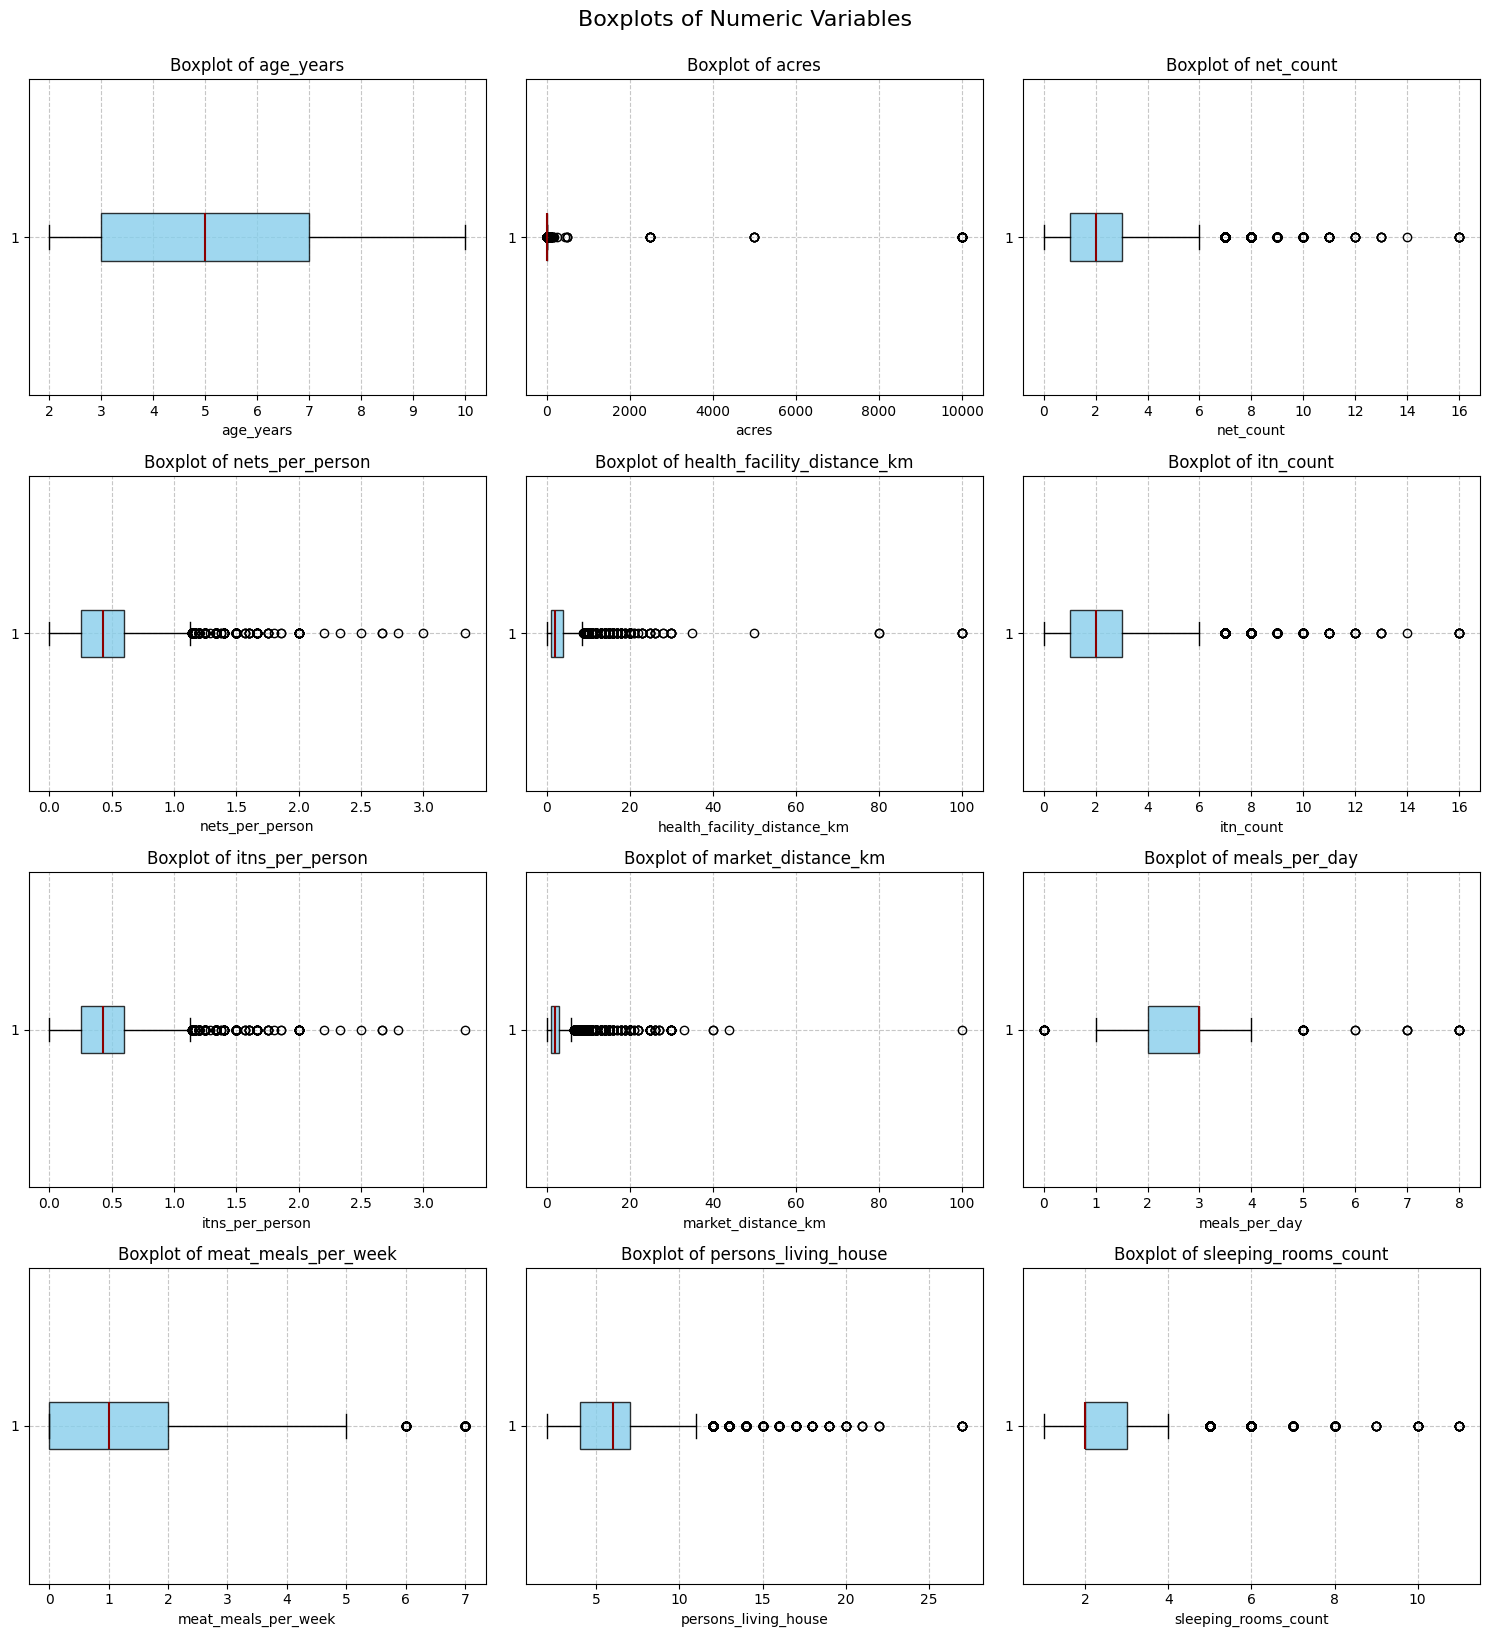

In [28]:
# Viewing boxplots of numeric variables to see outliers
plot_numeric_boxplots(df_merged, numeric_vars)

In [29]:
# Remove these extreme outliers as they may bias the results.
df_merged = df_merged[
    (df_merged["acres"] <= 2000) &
    (df_merged["health_facility_distance_km"] <= 40) &
    (df_merged["market_distance_km"] <= 38)
]

##### Scale the numeric data

In [30]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform the numeric columns directly
df_merged[numeric_vars] = scaler.fit_transform(df_merged[numeric_vars])

##### Perform a few sanity checks to make sure the data is clean

In [31]:
# First convert all columns to numeric
df_merged = df_merged.apply(pd.to_numeric)

In [32]:
# Make sure all columns are numeric
non_numeric_cols = df_merged.select_dtypes(exclude=["int32", "bool", "int64", "float64"]).columns.tolist()

if not non_numeric_cols:
    print("All columns are numeric.")
else:
    print("The following columns are NOT numeric:")
    print(non_numeric_cols)

The following columns are NOT numeric:
['water_source_onehot_Borehole', 'water_source_onehot_Bottled water', 'water_source_onehot_Bought from hawkers', 'water_source_onehot_Dam', 'water_source_onehot_Gravitational', 'water_source_onehot_Open public well', 'water_source_onehot_Open well in yard or compound', 'water_source_onehot_Piped into dwelling', 'water_source_onehot_Piped into the yard or compound', 'water_source_onehot_Pond, lake, or swamp', 'water_source_onehot_Protected public well', 'water_source_onehot_Protected spring', 'water_source_onehot_Protected well in yard or compound', 'water_source_onehot_Public or private tap', 'water_source_onehot_Rainwater', 'water_source_onehot_River or stream', 'water_source_onehot_Shallow well', 'water_source_onehot_Unprotected spring', 'water_source_onehot_Water tank', 'water_source_onehot_Water truck', 'eave_type_onehot_Open', 'floor_type_onehot_Bricks', 'floor_type_onehot_Cement or concrete', 'floor_type_onehot_Earth and dung', 'floor_type_o

In [33]:
remaining_categoricals = [col for col in categorical_vars if col in df_merged.columns]

if not remaining_categoricals:
    print("All original categorical variables have been dropped.")
else:
    print("The following original categorical variables are still present:")
    print(remaining_categoricals)


All original categorical variables have been dropped.


In [34]:
missing_scaled = [col for col in numeric_vars if f"{col}_scaled" not in df_merged.columns]

if not missing_scaled:
    print("All numeric variables have corresponding scaled versions.")
else:
    print("The following numeric variables were not scaled:")
    print(missing_scaled)


The following numeric variables were not scaled:
['age_years', 'acres', 'net_count', 'nets_per_person', 'health_facility_distance_km', 'itn_count', 'itns_per_person', 'market_distance_km', 'meals_per_day', 'meat_meals_per_week', 'persons_living_house', 'sleeping_rooms_count']


In [35]:
# Make a copy of the dataframe
df_clean = df_merged.copy(deep=True).reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 108 entries, age_years to wall_material_onehot_Un-burned bricks with plaster or cement
dtypes: float64(12), int32(1), int64(19), int8(76)
memory usage: 9.5 MB


# Exploratory Data Analysis (EDA)

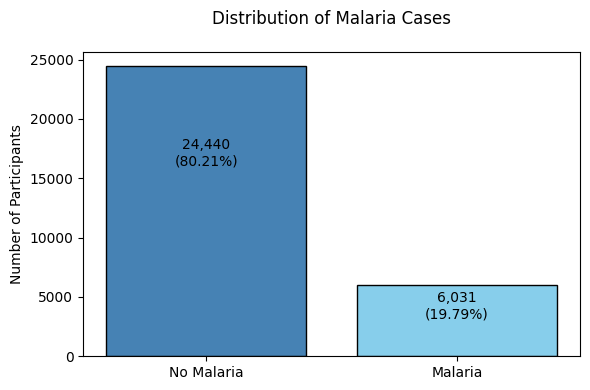

In [36]:
# Bar plot of the target variable - malria
# Compute counts and percentages
malaria_counts = df_clean["malaria"].value_counts().sort_index()
malaria_percentages = (malaria_counts / malaria_counts.sum() * 100).round(2)

# Bar plot with more compact height
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(
    x=["No Malaria", "Malaria"],
    height=malaria_counts.values,
    color=["#4682B4", "#87CEEB"],
    edgecolor='black'
)

# Annotate inside the bars
for i, bar in enumerate(bars):
    count = malaria_counts.values[i]
    percent = malaria_percentages.values[i]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 0.7,  # halfway up the bar
        f"{count:,}\n({percent}%)",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

# Labels and title
ax.set_ylabel("Number of Participants")
ax.set_title("Distribution of Malaria Cases", pad=20)
plt.tight_layout()
plt.savefig('./figures/malaria_class_distribution.png')
plt.show()

In [37]:
df_clean.describe()

,age_years,bednet_used_last_night,sex,acres,bank_account,has_bed,net_count,nets_per_person,has_bicycle,has_cassette_player,...,wall_material_onehot_Mud and poles,wall_material_onehot_Mud and stone,"wall_material_onehot_Mud, poles, and cement","wall_material_onehot_Mud, poles, and plaster",wall_material_onehot_Stone,"wall_material_onehot_Stone, plaster, and cement",wall_material_onehot_Thatched or straw,wall_material_onehot_Timber,wall_material_onehot_Un-burned bricks,wall_material_onehot_Un-burned bricks with plaster or cement
count,3.047100e+04,30471.000000,30471.000000,3.047100e+04,30471.000000,30471.000000,3.047100e+04,3.047100e+04,30471.000000,30471.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000
mean,1.016693e-16,0.700732,1.514719,-7.461970e-18,0.196810,0.942634,9.700560e-17,1.343155e-16,0.292803,0.095501,...,0.433264,0.000033,0.000033,0.000033,0.004004,0.000066,0.001411,0.000919,0.035903,0.036067
std,1.000016e+00,0.457945,0.499792,1.000016e+00,0.397594,0.232544,1.000016e+00,1.000016e+00,0.455056,0.293910,...,0.495534,0.005729,0.005729,0.005729,0.063150,0.008101,0.037540,0.030300,0.186051,0.186460
min,-1.381644e+00,0.000000,1.000000,-3.663475e-01,0.000000,0.000000,-1.507400e+00,-1.618487e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.608409e-01,0.000000,1.000000,-2.365972e-01,0.000000,1.000000,-8.958867e-01,-6.878779e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.192351e-01,1.000000,2.000000,-1.068468e-01,0.000000,1.000000,-2.843734e-01,-2.315700e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.223707e-01,1.000000,2.000000,2.290357e-02,0.000000,1.000000,3.271398e-01,6.149751e-01,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.984779e+00,1.000000,2.000000,6.450884e+01,1.000000,1.000000,8.276812e+00,1.078964e+01,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
# Basic descriptive statistics for the numeric vars only
summary_df = df_clean[numeric_vars].describe().T  # Transpose for better format

# Rename the index to 'variable' if you want
summary_df.index.name = 'variable'

# Optional: rename columns to match your example
summary_df = summary_df.rename(columns={
    "count": "count",
    "mean": "mean",
    "std": "stddev",
    "min": "min",
    "25%": "25%",
    "50%": "50%",
    "75%": "75%",
    "max": "max"
})

# Optional: round for cleaner display
summary_df = summary_df.round(3)

# Display result
print(summary_df.to_string())

                               count  mean  stddev    min    25%    50%    75%     max
variable                                                                              
age_years                    30471.0   0.0     1.0 -1.382 -0.961 -0.119  0.722   1.985
acres                        30471.0  -0.0     1.0 -0.366 -0.237 -0.107  0.023  64.509
net_count                    30471.0   0.0     1.0 -1.507 -0.896 -0.284  0.327   8.277
nets_per_person              30471.0   0.0     1.0 -1.618 -0.688 -0.023  0.615  10.790
health_facility_distance_km  30471.0  -0.0     1.0 -1.146 -0.726 -0.307  0.532  13.539
itn_count                    30471.0   0.0     1.0 -1.469 -0.862 -0.255  0.352   8.243
itns_per_person              30471.0   0.0     1.0 -1.572 -0.650  0.009  0.641  10.721
market_distance_km           30471.0   0.0     1.0 -1.043 -0.630 -0.218  0.195  12.569
meals_per_day                30471.0   0.0     1.0 -4.274 -0.859  0.849  0.849   9.387
meat_meals_per_week          30471.0   0.0 

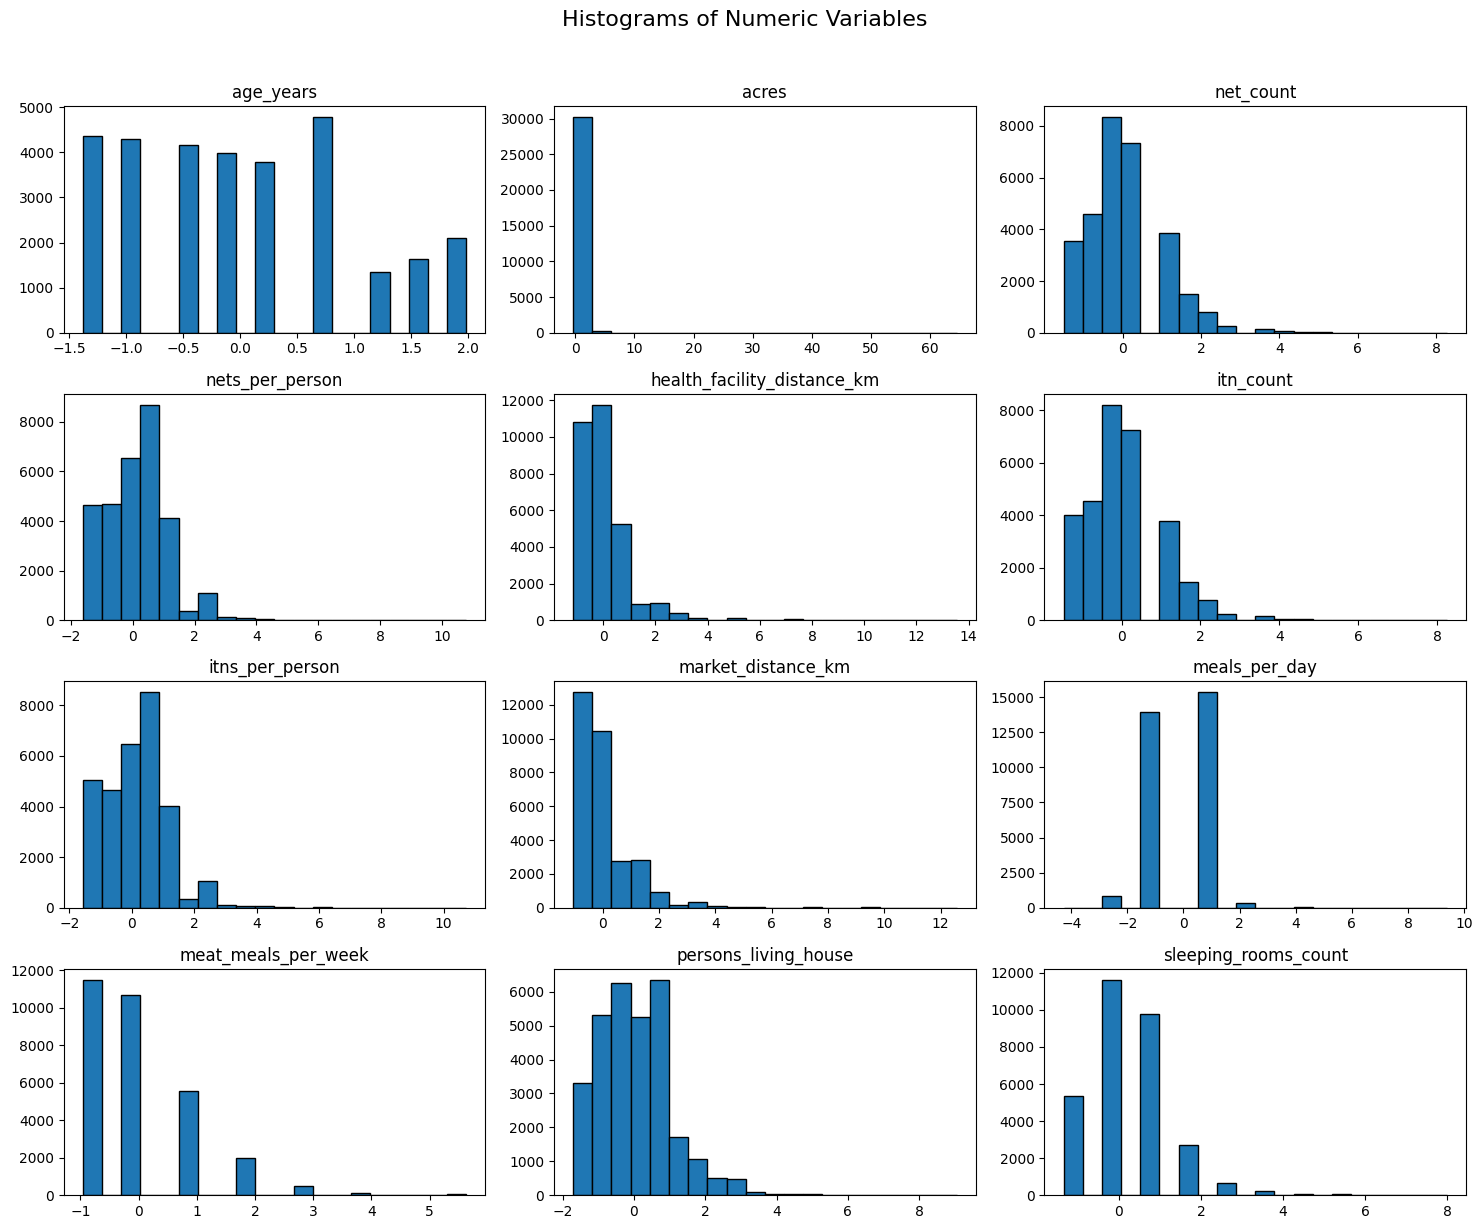

In [39]:
# Plot histograms of numeric variables
df_clean[numeric_vars].hist(
    figsize=(15, 12),
    bins=20,
    edgecolor='black',
    grid=False
)

plt.suptitle("Histograms of Numeric Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [40]:
def find_highly_correlated_features(df, numeric_vars, threshold=0.75):
    """
    Identifies highly correlated feature pairs based on the given threshold.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    numeric_vars (list): List of numeric column names.
    threshold (float): Correlation threshold to flag high correlation.

    Returns:
    list: List of (var1, var2, correlation) tuples for highly correlated pairs.
    """
    # Compute correlation matrix
    corr_matrix = df[numeric_vars].corr()

    # Store pairs
    high_corr_pairs = []

    # Check upper triangle of the correlation matrix (excluding diagonal)
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > threshold:
                high_corr_pairs.append((col1, col2, round(corr_val, 3)))

    # Print results
    if high_corr_pairs:
        print("Highly Correlated Pairs (|correlation| > {:.2f}):".format(threshold))
        for pair in high_corr_pairs:
            print(pair)
    else:
        print("No highly correlated pairs found above the threshold.")

    return high_corr_pairs

In [41]:
# Show the highly correlated pairs
correlated_pairs = find_highly_correlated_features(df_clean, numeric_vars, threshold=0.75)

Highly Correlated Pairs (|correlation| > 0.75):
('net_count', 'nets_per_person', 0.756)
('net_count', 'itn_count', 0.984)
('nets_per_person', 'itns_per_person', 0.978)
('itn_count', 'itns_per_person', 0.766)


In [42]:
# Remove fields that are highly correlated as they are not necessary
columns_to_remove = ["nets_per_person", "itn_count", "itns_per_person"]
df_clean = df_clean.drop(columns=columns_to_remove, errors="ignore")

In [43]:
# Update the list of numeric variables
numeric_vars = [
    'age_years', 'acres', 'net_count', 'health_facility_distance_km', 'market_distance_km',
    'meals_per_day', 'meat_meals_per_week', 'persons_living_house', 'sleeping_rooms_count'
]

In [44]:
# Show the highly correlated pairs
correlated_pairs = find_highly_correlated_features(df_clean, numeric_vars, threshold=0.75)

No highly correlated pairs found above the threshold.


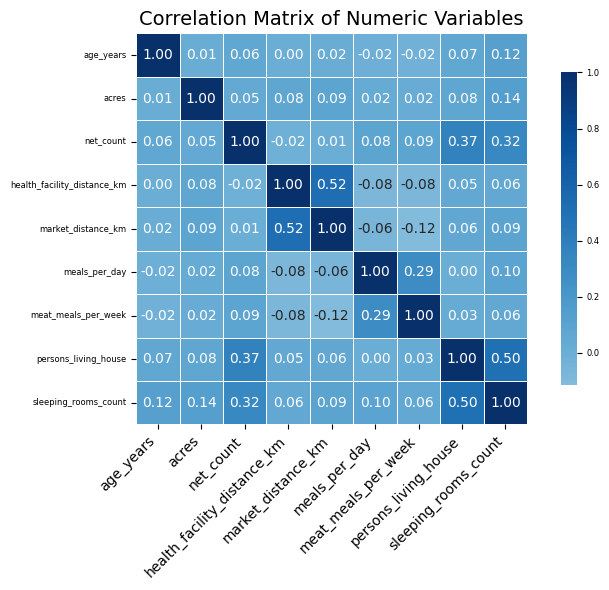

In [75]:
# Display a heatmap of numeric variables
# Compute correlation matrix directly from the DataFrame
corr_df = df_merged[numeric_vars].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_df,
    annot=True,           # Show correlation values
    fmt=".2f",            # Format numbers
    cmap="Blues",      # Color scheme
    center=0,             # Center the colormap at 0
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix of Numeric Variables", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [46]:
# Save the clean dataset
df_clean.to_csv("df_clean.csv", index=False)

# Housing Protection Score

In [47]:
# Define all the housing variables
housing_vars = ['windows_covered', 'sleeping_rooms_count', 'persons_living_house', 'net_count', 'bednet_used_last_night']

# Include all one-hot columns related to housing characteristics
housing_vars += [col for col in df_clean.columns if col.startswith((
    'floor_type_onehot_',
    'wall_material_onehot_',
    'eave_type_onehot_',
    'lighting_source_onehot_',
    'water_source_onehot_',
    'human_waste_facilities_onehot_'
))]

## Individual characteristics

In [48]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Define X (features) and y (target)
X = df_clean[housing_vars]
y = df_clean['malaria']

# Split the data for model training and evaluation
# Use stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Enough trees for stable prediction
    max_depth=None,    # No depth limit for maximum performance
    min_samples_leaf=10,  # To avoid overfitting on small leaf nodes
    random_state=RANDOM_SEED,
    n_jobs=-1   # Use all available processors
)

# Train the model on training data
rf_model.fit(X_train, y_train)

# Evaluate model performance
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
cv_scores = cross_val_score(rf_model, X, y, cv=5)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Make predictions on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC-ROC: {test_auc:.4f}")



Train Accuracy: 0.8178
Test Accuracy: 0.8105
Cross-validation scores: [0.79130435 0.79307516 0.80095176 0.79996718 0.80653101]
Mean CV Accuracy: 0.7984
Test AUC-ROC: 0.7832


In [49]:
# Calculate Housing Protection Score for all households
# This is done on the full dataset (using the trained model)
# Housing Protection Score = 1 - P(malaria|housing features)
housing_protection_scores = 1 - rf_model.predict_proba(X)[:, 1]
df_clean['housing_protection_score'] = housing_protection_scores

# Show distribution statistics of the housing protection score
print("\nHousing Protection Score Distribution:")
print(df_clean['housing_protection_score'].describe())

# Create quintiles using rank-based method to handle potential ties
df_clean['rank'] = df_clean['housing_protection_score'].rank(method='first')
df_clean['housing_protection_quintile'] = pd.qcut(
    df_clean['rank'], 
    q=5, 
    labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']
)

# Calculate correlation between housing protection score and malaria status
correlation = df_clean['housing_protection_score'].corr(df_clean['malaria'])
print(f"\nCorrelation between Housing Protection Score and Malaria: {correlation:.4f}")
# Note: We expect a negative correlation since higher protection score should mean lower malaria risk

# Calculate malaria prevalence by housing protection quintile
quintile_malaria_rates = df_clean.groupby('housing_protection_quintile', observed=True)['malaria'].mean() * 100
print("\nMalaria Prevalence (%) by Housing Protection Quintile:")
print(quintile_malaria_rates)




Housing Protection Score Distribution:
count    30471.000000
mean         0.801744
std          0.132219
min          0.350640
25%          0.711878
50%          0.842674
75%          0.905286
max          0.986817
Name: housing_protection_score, dtype: float64

Correlation between Housing Protection Score and Malaria: -0.4677

Malaria Prevalence (%) by Housing Protection Quintile:
housing_protection_quintile
Q1 (Lowest)     51.550451
Q2              25.664588
Q3              13.702002
Q4               6.071546
Q5 (Highest)     1.969150
Name: malaria, dtype: float64


In [50]:
# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

print("\nTop 15 Housing Features for Malaria Prediction:")
print(feature_importances.head(15))


Top 15 Housing Features for Malaria Prediction:
                                              Feature  Importance
5                        water_source_onehot_Borehole    0.282405
3                                           net_count    0.074070
2                                persons_living_house    0.072902
18          water_source_onehot_Public or private tap    0.070032
43                 lighting_source_onehot_Electricity    0.041230
4                              bednet_used_last_night    0.040153
1                                sleeping_rooms_count    0.039960
53        wall_material_onehot_Burned bricks with mud    0.029261
59                 wall_material_onehot_Mud and poles    0.027758
16               water_source_onehot_Protected spring    0.027087
27               floor_type_onehot_Cement or concrete    0.026500
25                              eave_type_onehot_Open    0.018408
50          lighting_source_onehot_Paraffin wick lamp    0.017504
36  human_waste_facilities_

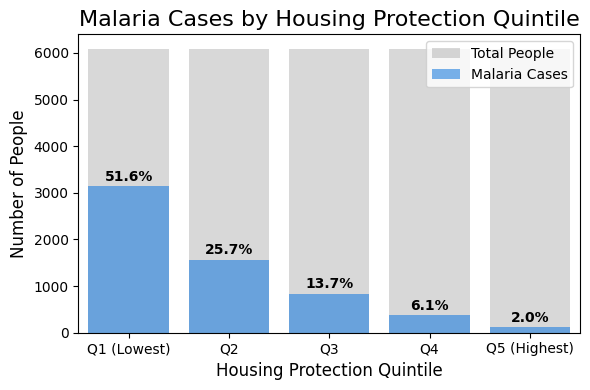

In [51]:
# Create a bar chart showing malaria cases by housing protection quintile
malaria_counts = df_clean.groupby('housing_protection_quintile', observed=True)['malaria'].sum().astype(int)
total_counts = df_clean.groupby('housing_protection_quintile', observed=True).size()

malaria_count_df = pd.DataFrame({
    'Quintile': malaria_counts.index,
    'Malaria Cases': malaria_counts.values,
    'Total People': total_counts.values
})

plt.figure(figsize=(6, 4))
# Plot total people in each quintile as background bars
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df, alpha=0.3, color='gray', label='Total People')
# Plot malaria cases as foreground bars
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df, alpha=0.6, color='#007FFF', label='Malaria Cases')

# Add percentage labels on top of each bar
for i, row in malaria_count_df.iterrows():
    percentage = (row['Malaria Cases'] / row['Total People']) * 100
    plt.text(i, row['Malaria Cases'] + 50, f"{percentage:.1f}%", 
             ha='center', va='bottom', color='black', fontweight='bold')

plt.title('Malaria Cases by Housing Protection Quintile', fontsize=16)
plt.xlabel('Housing Protection Quintile', fontsize=12)
plt.ylabel('Number of People', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./figures/malaria_by_protection_quintile.png', dpi=300, bbox_inches='tight')
plt.show()

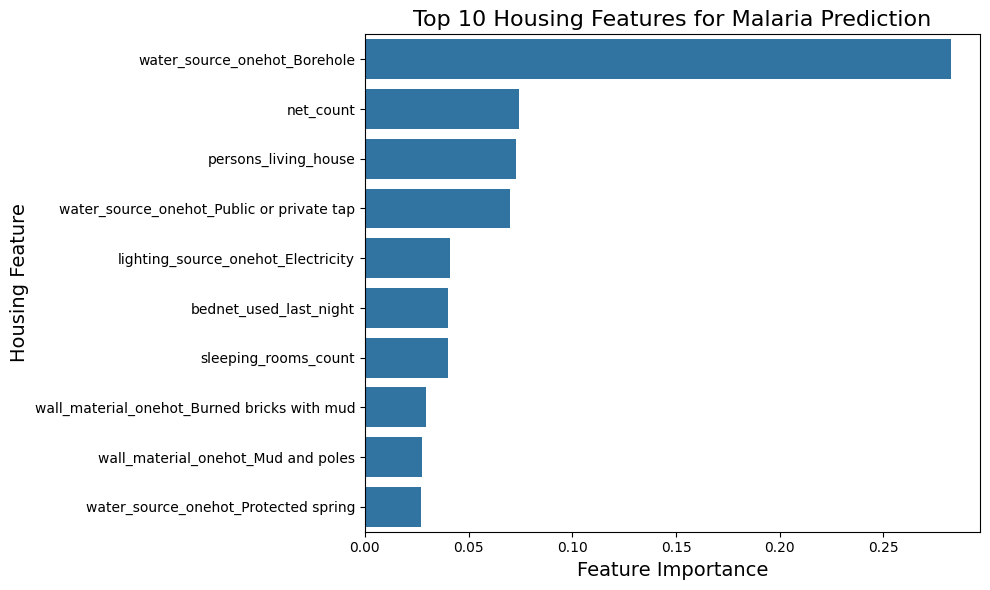

In [52]:
# Create a horizontal bar chart for the top 10 features
plt.figure(figsize=(10, 6))
top_features = feature_importances.head(10)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Housing Features for Malaria Prediction', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Housing Feature', fontsize=14)
plt.tight_layout()
plt.savefig('top_housing_features.png', dpi=300, bbox_inches='tight')
plt.show()



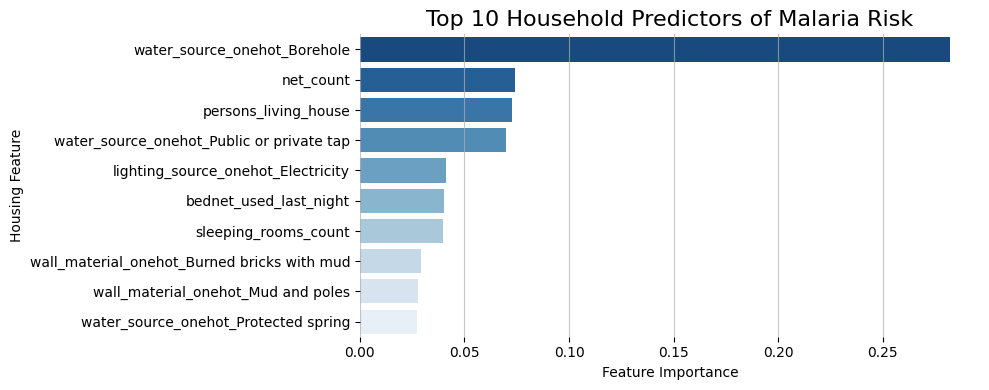

In [53]:
plt.figure(figsize=(10, 4))

top_features = feature_importances.head(10)

# Use a blue color palette
sns.barplot(x='Importance', y='Feature', data=top_features, palette="Blues_r", hue='Feature')

#  Title and labels
plt.title('Top 10 Household Predictors of Malaria Risk', fontsize=16)
plt.xlabel('Feature Importance', fontsize=10)  # Changed x-axis label
plt.ylabel('Housing Feature', fontsize=10)

plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels

# Add gridlines
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Remove spines
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('./figures/top_housing_features.png', dpi=300, bbox_inches='tight')
plt.show()


## Combined characteristics

In [54]:
# Define the mother categories and their corresponding columns
category_columns = {
    'windows_covered': ['windows_covered'],
    'sleeping_rooms_count': ['sleeping_rooms_count'],
    'persons_living_house': ['persons_living_house'],
    'net_count': ['net_count'],
    'bednet_used_last_night': ['bednet_used_last_night'],
    'floor_type': [col for col in df_clean.columns if col.startswith('floor_type_onehot_')],
    'wall_material': [col for col in df_clean.columns if col.startswith('wall_material_onehot_')],
    'eave_type': [col for col in df_clean.columns if col.startswith('eave_type_onehot_')],
    'lighting_source': [col for col in df_clean.columns if col.startswith('lighting_source_onehot_')],
    'water_source': [col for col in df_clean.columns if col.startswith('water_source_onehot_')],
    'human_waste_facilities': [col for col in df_clean.columns if col.startswith('human_waste_facilities_onehot_')]
}

# Print the number of variables in each category
print("Number of variables in each category:")
for category, cols in category_columns.items():
    print(f"{category}: {len(cols)} variables")
print()

Number of variables in each category:
windows_covered: 1 variables
sleeping_rooms_count: 1 variables
persons_living_house: 1 variables
net_count: 1 variables
bednet_used_last_night: 1 variables
floor_type: 8 variables
wall_material: 16 variables
eave_type: 1 variables
lighting_source: 11 variables
water_source: 20 variables
human_waste_facilities: 8 variables



In [55]:
# Gather all housing variables
all_housing_vars = []
for cols in category_columns.values():
    all_housing_vars.extend(cols)

# Define X (features) and y (target)
X = df_clean[all_housing_vars]
y = df_clean['malaria']

# Split the data for model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Enough trees for stable prediction
    max_depth=None,    # No depth limit for maximum performance
    min_samples_leaf=10,  # To avoid overfitting on small leaf nodes
    random_state=RANDOM_SEED,
    n_jobs=-1   # Use all available processors
)

# Train the model on training data
rf_model.fit(X_train, y_train)

# Evaluate model performance
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
cv_scores = cross_val_score(rf_model, X, y, cv=5)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Make predictions on test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC-ROC: {test_auc:.4f}")
print()

Train Accuracy: 0.8176
Test Accuracy: 0.8097
Mean CV Accuracy: 0.7985
Test AUC-ROC: 0.7842



In [56]:
# Function to calculate permutation importance for grouped features
def calculate_grouped_permutation_importance(model, X, y, category_columns, n_repeats=10):
    """
    Calculate permutation importance for groups of features.
    
    For each group, we permute all features in the group together,
    which preserves correlations within the group but breaks correlations
    with the target variable.
    """
    X = X.copy()
    grouped_importance = {}
    
    for category, cols in category_columns.items():
        scores = []
        baseline_score = model.score(X, y)
        
        # Repeat the permutation multiple times for stability
        for _ in range(n_repeats):
            # Create a copy to permute
            X_permuted = X.copy()
            
            # Permute all features in this group together
            permutation_idx = np.random.permutation(len(X))
            X_permuted[cols] = X_permuted[cols].iloc[permutation_idx].values
            
            # Calculate the drop in performance
            permuted_score = model.score(X_permuted, y)
            score_drop = baseline_score - permuted_score
            scores.append(score_drop)
        
        # Average the importance scores
        grouped_importance[category] = np.mean(scores)
    
    # Create a dataframe with the results
    result_df = pd.DataFrame({
        'Category': list(grouped_importance.keys()),
        'Importance': list(grouped_importance.values())
    }).sort_values('Importance', ascending=False)
    
    return result_df

# Calculate permutation importance for grouped features
permutation_results = calculate_grouped_permutation_importance(
    rf_model, X_test, y_test, category_columns
)

print(permutation_results)
print()

                  Category  Importance
9             water_source    0.007039
6            wall_material    0.004233
10  human_waste_facilities    0.002691
5               floor_type    0.002527
2     persons_living_house    0.002018
3                net_count    0.002018
8          lighting_source    0.001575
0          windows_covered    0.001181
7                eave_type    0.000705
1     sleeping_rooms_count    0.000705
4   bednet_used_last_night    0.000492



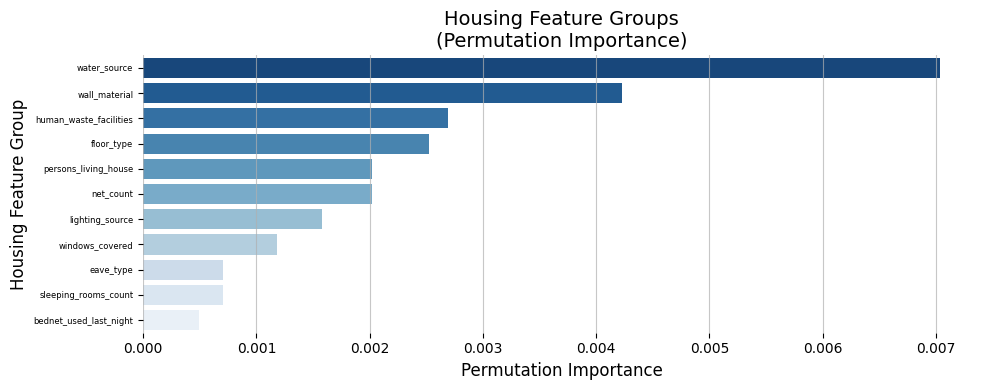

In [57]:
plt.figure(figsize=(10, 4))

# Use a blue color palette
sns.barplot(x='Importance', y='Category', data=permutation_results, palette="Blues_r", hue='Category')

#  Title and labels
plt.title('Housing Feature Groups\n(Permutation Importance)', fontsize=14)
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Housing Feature Group', fontsize=12)

plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels

# Add gridlines
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Remove spines
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('./figures/top_housing_features_grouped.png', dpi=300, bbox_inches='tight')
plt.show()

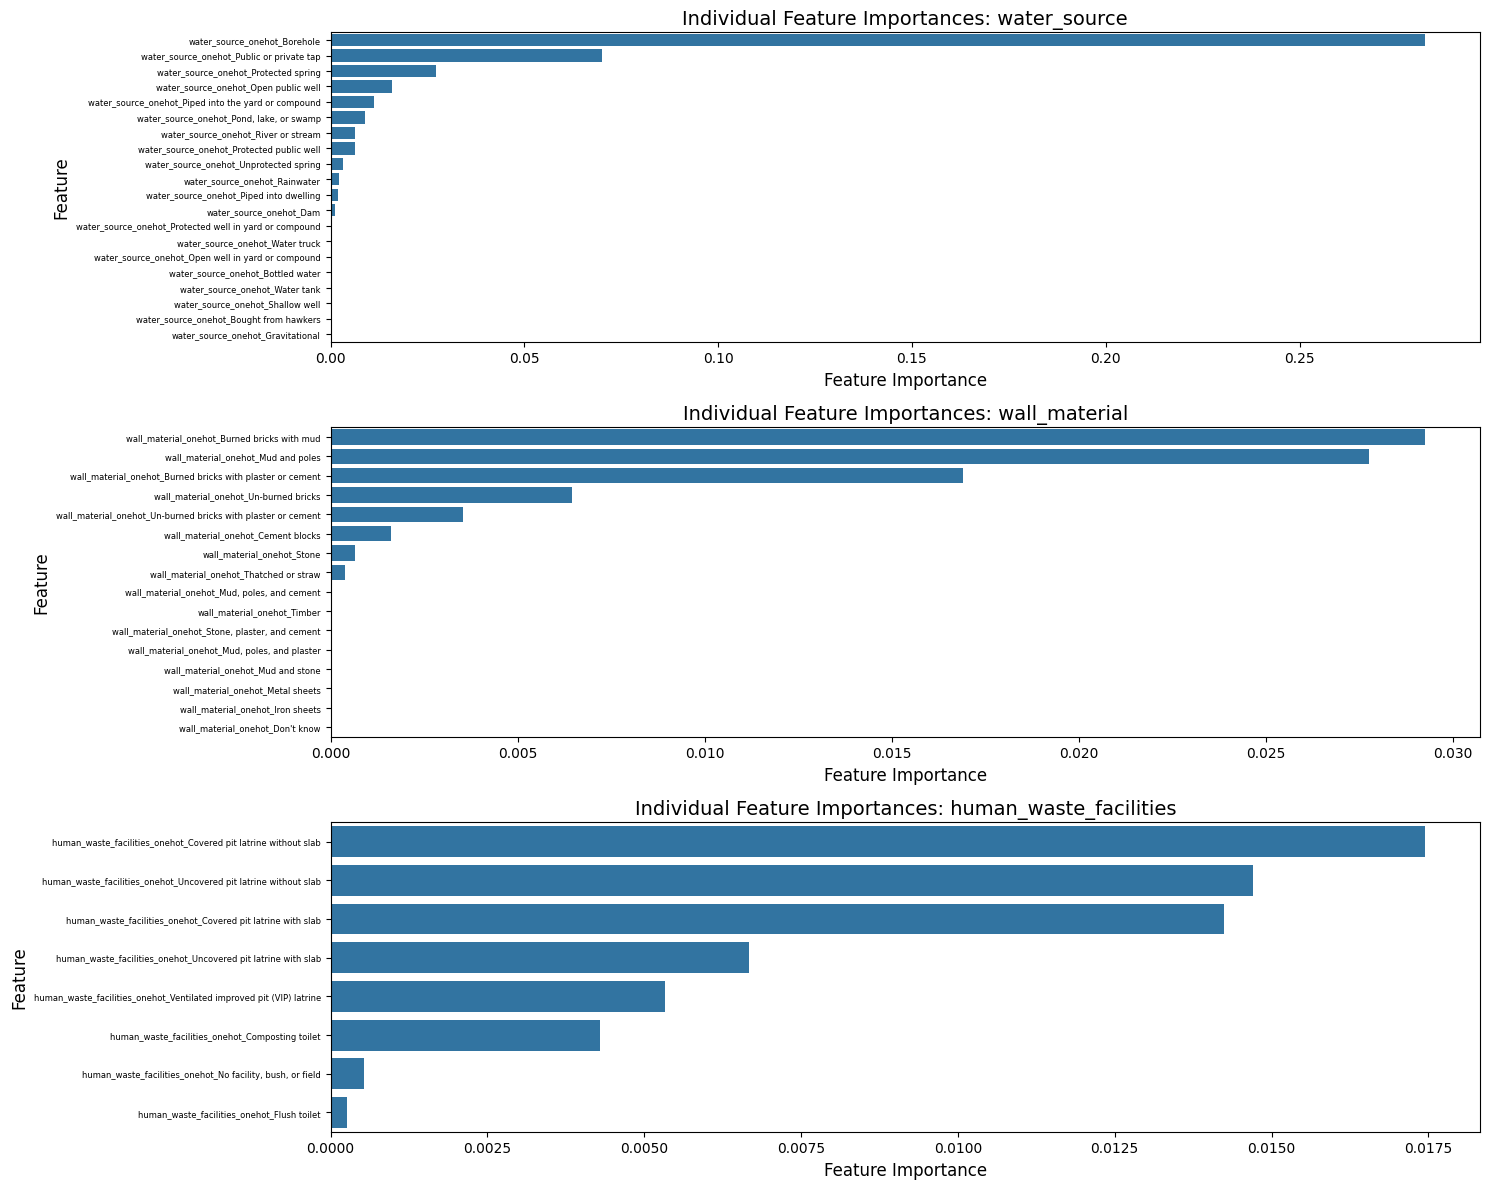

In [58]:
# Visualize the individual feature importances within the top categories
# Get the top 3 categories based on permutation importance
top_categories = permutation_results['Category'].head(3).tolist()

plt.figure(figsize=(15, 12))

for i, category in enumerate(top_categories):
    # Get columns for this category
    cols = category_columns[category]
    
    # Get importances for these columns
    cat_importances = feature_importances[feature_importances['Feature'].isin(cols)].sort_values('Importance', ascending=False)
    
    plt.subplot(3, 1, i+1)
    sns.barplot(x='Importance', y='Feature', data=cat_importances)
    plt.title(f'Individual Feature Importances: {category}', fontsize=14)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.savefig('top_categories_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

## Odds ratios for housing characteristics

In [59]:
# Construct composite housing feature variables

# Finished Floor: Bricks, cement, tiles, polished wood, or stones
df_clean["Finished_Floor"] = (
    (df_clean["floor_type_onehot_Bricks"] == 1)
    | (df_clean["floor_type_onehot_Cement or concrete"] == 1)
    | (df_clean["floor_type_onehot_Mosaic or tiles"] == 1)
    | (df_clean["floor_type_onehot_Parquet or polished wood"] == 1)
    | (df_clean["floor_type_onehot_Stones"] == 1)
).astype(int)

# Finished Walls: Includes plastered/cemented bricks, blocks, metal/iron sheets, timber, etc.
df_clean["Finished_Walls"] = (
    (df_clean["wall_material_onehot_Burned bricks with plaster or cement"] == 1)
    | (df_clean["wall_material_onehot_Cement blocks"] == 1)
    | (df_clean["wall_material_onehot_Iron sheets"] == 1)
    | (df_clean["wall_material_onehot_Metal sheets"] == 1)
    | (df_clean["wall_material_onehot_Mud, poles, and cement"] == 1)
    | (df_clean["wall_material_onehot_Mud, poles, and plaster"] == 1)
    | (df_clean["wall_material_onehot_Stone"] == 1)
    | (df_clean["wall_material_onehot_Stone, plaster, and cement"] == 1)
    | (df_clean["wall_material_onehot_Timber"] == 1)
    | (df_clean["wall_material_onehot_Un-burned bricks"] == 1)
    | (df_clean["wall_material_onehot_Un-burned bricks with plaster or cement"] == 1)
).astype(int)

# Closed Eaves: 1 if closed, 0 if open
df_clean["Closed_Eaves"] = (1 - df_clean["eave_type_onehot_Open"]).astype(int)

# Covered Windows: Already binary
df_clean["Covered_Windows"] = df_clean["windows_covered"].astype(int)


# Fit adjusted logistic regression model
# Define predictor variables and add constant
predictors = ["Finished_Floor", "Finished_Walls", "Closed_Eaves", "Covered_Windows", "age_years", "sex"]
X_adj = sm.add_constant(df_clean[predictors])
y = df_clean["malaria"]

# Fit logistic regression
model_adj = sm.Logit(y, X_adj).fit(disp=False)
summary_adj = model_adj.summary2().tables[1]


# Extract adjusted odds ratios and confidence intervals
features_to_extract = ["Finished_Floor", "Finished_Walls", "Closed_Eaves", "Covered_Windows"]
or_table = summary_adj.loc[features_to_extract].copy()

# Compute odds ratios and 95% confidence intervals
or_table["OR"] = np.exp(or_table["Coef."])
or_table["Lower CI"] = np.exp(or_table["Coef."] - 1.96 * or_table["Std.Err."])
or_table["Upper CI"] = np.exp(or_table["Coef."] + 1.96 * or_table["Std.Err."])
or_table["p-value"] = or_table["P>|z|"]

# Final formatting
or_table = or_table[["OR", "Lower CI", "Upper CI", "p-value"]]
or_table.reset_index(inplace=True)
or_table.rename(columns={"index": "Feature"}, inplace=True)

# Display the result
or_table

,Feature,OR,Lower CI,Upper CI,p-value
0,Finished_Floor,0.447874,0.414509,0.483924,6.175577e-92
1,Finished_Walls,1.551236,1.445157,1.665103,5.833985e-34
2,Closed_Eaves,0.908640,0.854492,0.966218,2.240974e-03
3,Covered_Windows,0.557203,0.494406,0.627976,9.131825e-22


### Effectiveness of Housing Features in Preventing Malaria

This analysis evaluated the association between specific housing features and the odds of malaria infection, adjusting for age and sex. The following housing features were considered: finished floors, finished walls, closed eaves, and covered windows.

#### Protective Housing Features

- **Finished Floors** showed a strong protective effect, with an odds ratio (OR) of **0.45** (95% CI: 0.41–0.48). This suggests that individuals living in homes with finished flooring (e.g., cement, tile, stone) had **55% lower odds** of malaria compared to those with unfinished floors. Finished floors likely reduce mosquito resting sites and improve indoor hygiene.

- **Covered Windows** were also associated with a significant reduction in malaria risk (OR = **0.56**, 95% CI: 0.49–0.63). This aligns with expectations, as covering windows limits mosquito entry into the household.

- **Closed Eaves** offered a modest but statistically significant protective effect (OR = **0.91**, 95% CI: 0.85–0.97). Although the reduction in odds is smaller, it reflects the importance of minimizing structural gaps in walls and roofs where mosquitoes can enter.

#### Counterintuitive Result: Finished Walls as a Risk Factor

Unexpectedly, **finished walls** were associated with **higher odds of malaria** (OR = **1.55**, 95% CI: 1.45–1.67), suggesting a **55% increase in malaria risk** relative to homes with unfinished walls. This finding contrasts with the general understanding that improved wall materials should offer better protection.

Several potential explanations may account for this counterintuitive result:

1. **Misclassification or Broad Categorization**: The "finished walls" variable encompasses a wide range of materials — including both high-quality (e.g., plastered brick) and lower-quality materials (e.g., iron sheets, timber) that may still permit mosquito entry or promote indoor resting.

2. **Confounding by Location or Wealth**: Households with finished walls may be concentrated in peri-urban or low-lying regions where malaria transmission is more intense, despite better housing. If these households are also wealthier, they may paradoxically live in areas with higher malaria vector density due to irrigation or development.

3. **Behavioral and Structural Factors**: Residents in better-built houses may keep windows and doors open for ventilation, negating structural advantages. Additionally, some wall materials (like metal sheets) may create heat stress, influencing indoor behavior and increasing mosquito exposure at night.

4. **Residual Confounding**: The association may reflect unmeasured confounders not included in the model — such as household wealth, presence of bed nets, use of insecticides, or housing density.



While most housing improvements show expected protective associations against malaria, the increased risk observed with finished walls highlights the importance of **careful variable construction** and **consideration of contextual factors**. Further investigation is warranted to disaggregate wall material types, control for geographic and behavioral factors, and explore interactions with environmental and socioeconomic conditions.

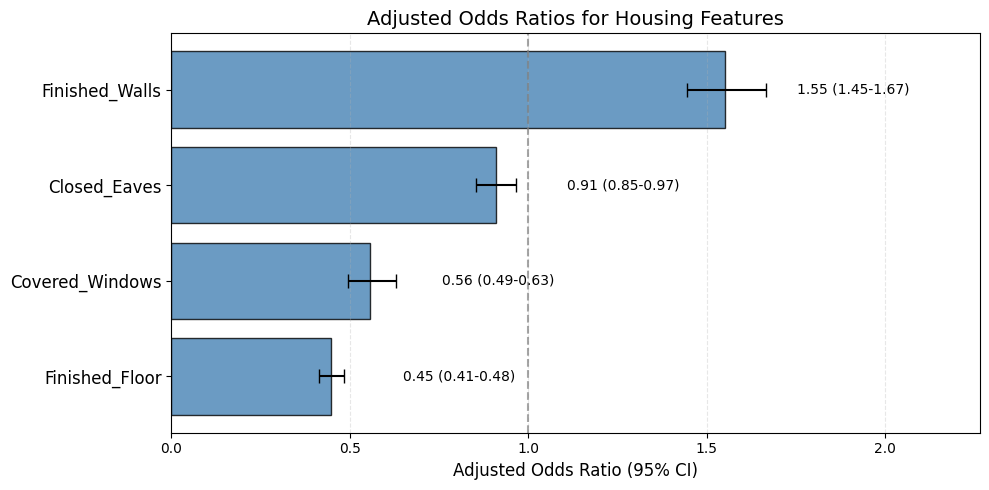

In [60]:


# Sort features by odds ratio for better visual structure
features = or_table["Feature"].tolist()
odds_ratios = or_table["OR"].values
ci_lower = or_table["Lower CI"].values
ci_upper = or_table["Upper CI"].values

sorted_indices = np.argsort(odds_ratios)
features_sorted = [features[i] for i in sorted_indices]
odds_sorted = odds_ratios[sorted_indices]
ci_lower_sorted = ci_lower[sorted_indices]
ci_upper_sorted = ci_upper[sorted_indices]

# Recalculate error bars
xerr_lower_sorted = odds_sorted - ci_lower_sorted
xerr_upper_sorted = ci_upper_sorted - odds_sorted

# Create plot
plt.figure(figsize=(10, 5))
y_pos = np.arange(len(features_sorted))

bars = plt.barh(
    y_pos,
    odds_sorted,
    xerr=[xerr_lower_sorted, xerr_upper_sorted],
    capsize=5,
    color='steelblue',
    edgecolor='black',
    alpha=0.8
)

# Vertical line at OR = 1
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.7)

plt.yticks(y_pos, features_sorted, fontsize=12)

# Y-axis labels and title
plt.yticks(y_pos, features_sorted)
plt.xlabel("Adjusted Odds Ratio (95% CI)", fontsize=12)  # Adjust as needed
plt.title("Adjusted Odds Ratios for Housing Features", fontsize=14)  # Adjust as needed


# Gridlines
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add text labels slightly further right
for i, (or_val, lo, hi) in enumerate(zip(odds_sorted, ci_lower_sorted, ci_upper_sorted)):
    plt.text(
        or_val + 0.2,  # slight increase in offset
        i,
        f"{or_val:.2f} ({lo:.2f}-{hi:.2f})",
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

# Adjust axis limits for better spacing
plt.xlim(0, max(ci_upper_sorted) + 0.6)
plt.tight_layout()
plt.savefig('./figures/housing_features_odds_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

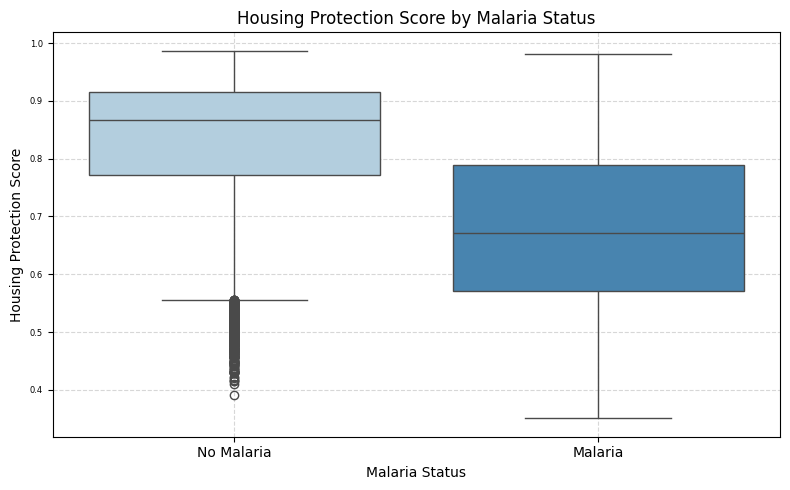

In [61]:
# Plot 2: Boxplot of Protection Score by Malaria Status
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_clean,
    x='malaria',
    y='housing_protection_score',
    hue='malaria',
    palette=sns.color_palette('Blues', 2),
    legend=False
)

plt.xticks([0, 1], ['No Malaria', 'Malaria'])
plt.title('Housing Protection Score by Malaria Status')
plt.xlabel('Malaria Status')
plt.ylabel('Housing Protection Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/housing_protection_score_by_malaria_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Socioeconomic Status

In [62]:
ses_vars = [
    'has_bed', 'has_chair', 'has_clock', 'has_cupboard', 'has_sofa', 'has_table', 'has_tv', 'has_watch',
    'has_radio', 'has_electricity', 'has_internet_device', 'has_mobile_phone',
    'bank_account', 'has_bicycle', 'has_motorcycle', 'market_distance_km', 'has_cassette_player',
    'meals_per_day', 'meat_meals_per_week', 'acres', 'health_facility_distance_km'
]

# Include all one-hot columns related to SES
ses_vars += [col for col in df_clean.columns if col.startswith((
    'transit_to_health_facility_onehot_',
    'food_insecurity_weekly_onehot_'
))]

In [63]:
# Extract SES data
ses_data = df_clean[ses_vars].dropna()

# Run PCA and retain the first component
pca = PCA(n_components=1)
ses_index = pca.fit_transform(ses_data).flatten()

# Create a new DataFrame to match the PCA output back to the original
df_ses = df_clean.loc[ses_data.index].copy()
# Flip the sign of the PCA index
df_ses['SES_Index'] = -ses_index

# Recreate SES quintiles with the corrected index direction
df_ses['SES_Quintile'] = pd.qcut(df_ses['SES_Index'], 5, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)'])

# Recalculate malaria prevalence by SES quintile
malaria_by_quintile = df_ses.groupby('SES_Quintile', observed=False)['malaria'].mean().reset_index()
malaria_by_quintile.columns = ['SES Quintile', 'Malaria Prevalence']



In [64]:
malaria_by_quintile

,SES Quintile,Malaria Prevalence
0,Q1 (Lowest),0.254593
1,Q2,0.237486
2,Q3,0.204628
3,Q4,0.178700
4,Q5 (Highest),0.114211


In [65]:
# Save the dataset to 
df_ses.to_csv("df_ses.csv", index=False)

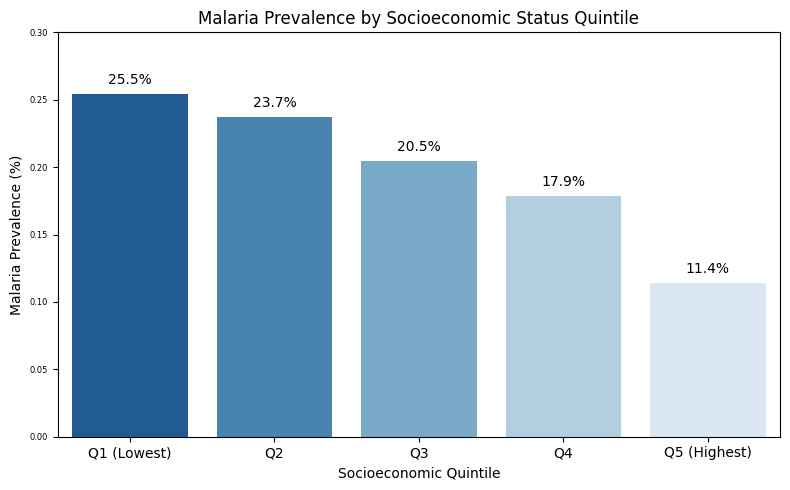

In [66]:
# Plot the SES Quintiles vs Malaria Prevalence
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=malaria_by_quintile,
    x='SES Quintile',
    y='Malaria Prevalence',
    hue='SES Quintile',
    legend=False,
    palette=sns.color_palette("Blues", 5)[::-1]  # reverse the palette
)

# Add percentage labels on each bar
for i, val in enumerate(malaria_by_quintile['Malaria Prevalence']):
    barplot.text(i, val + 0.005, f"{val * 100:.1f}%", ha='center', va='bottom', fontsize=10)

plt.title('Malaria Prevalence by Socioeconomic Status Quintile')
plt.ylabel('Malaria Prevalence (%)')
plt.xlabel('Socioeconomic Quintile')
plt.ylim(0, 0.3)
plt.tight_layout()
plt.show()

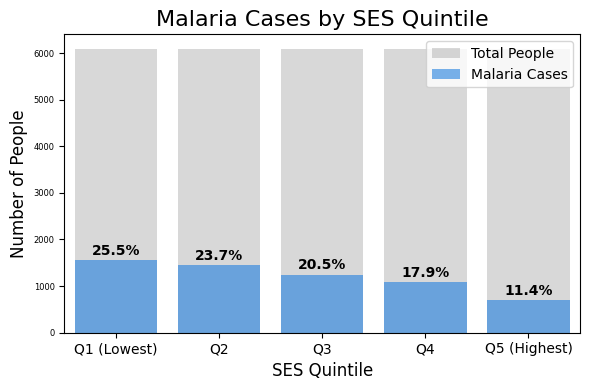

In [67]:
malaria_counts = df_ses.groupby('SES_Quintile', observed=True)['malaria'].sum().astype(int)
total_counts = df_ses.groupby('SES_Quintile', observed=True).size()

malaria_count_df = pd.DataFrame({
    'Quintile': malaria_counts.index,
    'Malaria Cases': malaria_counts.values,
    'Total People': total_counts.values
})

plt.figure(figsize=(6, 4))
# Plot total people in each quintile as background bars
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df, alpha=0.3, color='gray', label='Total People')
# Plot malaria cases as foreground bars
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df, alpha=0.6, color='#007FFF', label='Malaria Cases')

# Add percentage labels on top of each bar
for i, row in malaria_count_df.iterrows():
    percentage = (row['Malaria Cases'] / row['Total People']) * 100
    plt.text(i, row['Malaria Cases'] + 50, f"{percentage:.1f}%", 
             ha='center', va='bottom', color='black', fontweight='bold')

plt.title('Malaria Cases by SES Quintile', fontsize=16)
plt.xlabel('SES Quintile', fontsize=12)
plt.ylabel('Number of People', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./figures/malaria_by_ses_quintile.png', dpi=300, bbox_inches='tight')
plt.show()

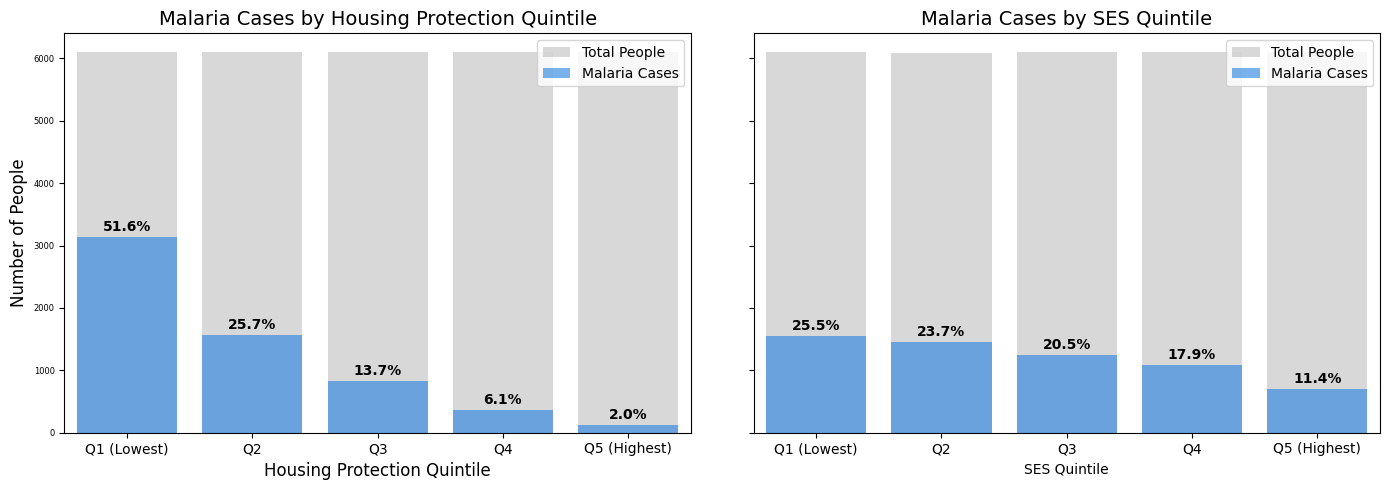

In [68]:
# First plot data (Housing Protection)
malaria_counts_hp = df_clean.groupby('housing_protection_quintile', observed=True)['malaria'].sum().astype(int)
total_counts_hp = df_clean.groupby('housing_protection_quintile', observed=True).size()

malaria_count_df_hp = pd.DataFrame({
    'Quintile': malaria_counts_hp.index,
    'Malaria Cases': malaria_counts_hp.values,
    'Total People': total_counts_hp.values
})

# Second plot data (SES)
malaria_counts_ses = df_ses.groupby('SES_Quintile', observed=True)['malaria'].sum().astype(int)
total_counts_ses = df_ses.groupby('SES_Quintile', observed=True).size()

malaria_count_df_ses = pd.DataFrame({
    'Quintile': malaria_counts_ses.index,
    'Malaria Cases': malaria_counts_ses.values,
    'Total People': total_counts_ses.values
})

# Create 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Housing Protection
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df_hp, alpha=0.3, color='gray', ax=axes[0], label='Total People')
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df_hp, alpha=0.6, color='#007FFF', ax=axes[0], label='Malaria Cases')

for i, row in malaria_count_df_hp.iterrows():
    pct = (row['Malaria Cases'] / row['Total People']) * 100
    axes[0].text(i, row['Malaria Cases'] + 50, f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

axes[0].set_title('Malaria Cases by Housing Protection Quintile', fontsize=14)
axes[0].set_xlabel('Housing Protection Quintile', fontsize=12)
axes[0].set_ylabel('Number of People', fontsize=12)
axes[0].legend(loc='upper right')

# Plot 2: SES
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df_ses, alpha=0.3, color='gray', ax=axes[1], label='Total People')
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df_ses, alpha=0.6, color='#007FFF', ax=axes[1], label='Malaria Cases')

for i, row in malaria_count_df_ses.iterrows():
    pct = (row['Malaria Cases'] / row['Total People']) * 100
    axes[1].text(i, row['Malaria Cases'] + 50, f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

axes[1].set_title('Malaria Cases by SES Quintile', fontsize=14)
axes[1].set_xlabel('SES Quintile')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)  # Increase horizontal space between the two plots

plt.savefig('./figures/malaria_by_quintiles_side_by_side.png', dpi=300, bbox_inches='tight')
plt.show()

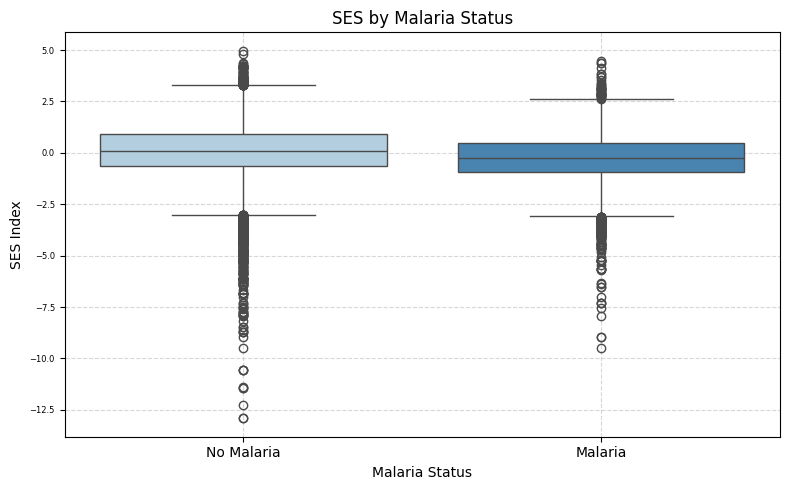

In [76]:
# Boxplot of Protection Score by Malaria Status
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_ses,
    x='malaria',
    y='SES_Index',
    hue='malaria',
    palette='Blues',
    legend=False
)

plt.xticks([0, 1], ['No Malaria', 'Malaria'])
plt.title('SES by Malaria Status')
plt.xlabel('Malaria Status')
plt.ylabel('SES Index')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [70]:
# Create SES quintile dummies (Q1 as reference)
ses_dummies = pd.get_dummies(df_ses['SES_Quintile'], drop_first=True)

# Ensure your target is numeric and aligned with predictors
y = df_ses['malaria'].astype(float)

# Create dummies for SES quintile (drop Q1 as reference)
ses_dummies = pd.get_dummies(df_ses['SES_Quintile'], drop_first=True)
X_unadj = sm.add_constant(ses_dummies).astype(float)

# Fit unadjusted model
model_unadj = sm.Logit(y, X_unadj).fit()
summary_unadj = model_unadj.summary2().tables[1]

# Add covariates and ensure everything is float
X_adj = pd.concat([ses_dummies, df_ses[['age_years', 'sex', 'housing_protection_score']]], axis=1)
X_adj = sm.add_constant(X_adj).astype(float)

# Fit adjusted model
model_adj = sm.Logit(y, X_adj).fit()

summary_adj = model_adj.summary2().tables[1]

# Extract ORs and confidence intervals
def extract_or_ci(summary, labels):
    ors = np.exp(summary['Coef.'])
    lower = np.exp(summary['Coef.'] - 1.96 * summary['Std.Err.'])
    upper = np.exp(summary['Coef.'] + 1.96 * summary['Std.Err.'])
    formatted = []
    for label in labels:
        formatted.append(f"{ors[label]:.2f} ({lower[label]:.2f}-{upper[label]:.2f})")
    return formatted

# Prepare row labels in order
quintile_labels = ['Q2', 'Q3', 'Q4', 'Q5 (Highest)']
row_labels = ['Low', 'Middle', 'High', 'Highest']

# Extract formatted ORs
unadj_or_ci = extract_or_ci(summary_unadj, quintile_labels)
adj_or_ci = extract_or_ci(summary_adj, quintile_labels)

# Assemble table
table_data = pd.DataFrame({
    'SES Quintile': ['Lowest'] + row_labels,
    'Unadjusted OR (95% CI)': ['Reference'] + unadj_or_ci,
    'Adjusted OR (95% CI)': ['Reference'] + adj_or_ci
})
table_data


Optimization terminated successfully.
         Current function value: 0.489381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391890
         Iterations 7


,SES Quintile,Unadjusted OR (95% CI),Adjusted OR (95% CI)
0,Lowest,Reference,Reference
1,Low,0.91 (0.84-0.99),0.94 (0.86-1.04)
2,Middle,0.75 (0.69-0.82),0.77 (0.70-0.85)
3,High,0.64 (0.58-0.70),0.80 (0.72-0.88)
4,Highest,0.38 (0.34-0.42),0.73 (0.65-0.81)


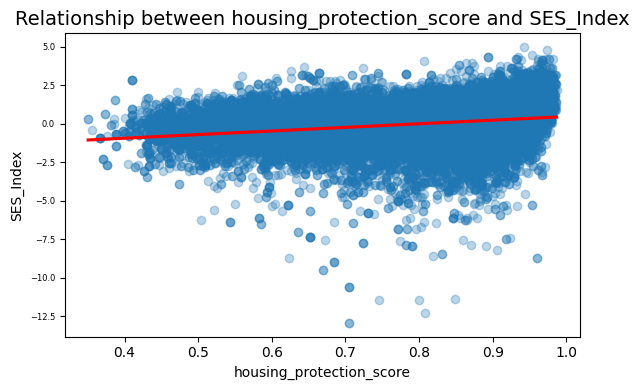

In [71]:
# Create the plot
plt.figure(figsize=(6, 4))
sns.regplot(
    x='housing_protection_score',
    y='SES_Index',
    data=df_ses,
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

# Add labels and title
plt.title('Relationship between housing_protection_score and SES_Index', fontsize=14)
plt.xlabel('housing_protection_score')
plt.ylabel('SES_Index')

# Clean layout
plt.tight_layout()
plt.savefig('./figures/relationship_housing_prot_score_ses.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### Relationship Between Housing Protection Score and SES Index

The scatterplot below shows the relationship between `housing_protection_score` (x-axis) and `SES_Index` (y-axis), with a fitted linear regression line in red.

#### Interpretation

- **Positive Linear Trend**:  
  The regression line slopes slightly upward, indicating a **positive relationship** between housing protection and SES. This is consistent with the mediation coefficient `a = 0.234`, suggesting that as housing protection improves, SES tends to increase.

- **Statistically Significant Association**:  
  This trend is statistically significant (p < 0.001), supporting the idea that better housing is associated with higher socioeconomic status.

- **High Variability / Weak Association**:  
  The scatter of points around the regression line is wide, especially at higher housing protection scores. Many households with good housing conditions still have relatively low SES, and vice versa. This indicates that the **association is real but not strong**.

- **Right-Skewed Distribution**:  
  Most data points are concentrated toward the higher end of the housing protection score (around 0.7–1.0), suggesting many households have relatively protective housing. However, their SES varies considerably within that range.

#### Implications for Mediation

This pattern supports the **partial mediation** conclusion from earlier analysis:

- Housing protection score **does influence SES**, but only modestly.
- This modest relationship helps explain why the **proportion of the housing–malaria relationship mediated by SES is small (~2%)**.
- The majority of housing’s protective effect against malaria operates **directly** — through physical features that reduce mosquito exposure — **rather than indirectly through SES improvements**.

# Summary statistics

In [72]:
# Load the dataset
df = pd.read_csv("df_ses.csv")

# Unscale age_years using provided original mean and std
original_mean = 5.283968
original_std = 2.378111
df['age_years'] = df['age_years'] * original_std + original_mean

# Derived binary variables
df["female"] = (df["sex"] == 2).astype(int)
df["open_eaves"] = (df["Closed_Eaves"] == 0).astype(int)

# Label mapping for quintiles
quintile_map = {
    'Q1': 'Q1 (Lowest)',
    'Q5': 'Q5 (Highest)'
}
df['SES_Quintile'] = df['SES_Quintile'].replace(quintile_map)
df['housing_protection_quintile'] = df['housing_protection_quintile'].replace(quintile_map)

# Split by malaria status
malaria_pos = df[df["malaria"] == 1]
malaria_neg = df[df["malaria"] == 0]

# Helper functions
def binary_summary(var):
    pos_count = malaria_pos[var].sum()
    pos_pct = 100 * pos_count / len(malaria_pos)
    neg_count = malaria_neg[var].sum()
    neg_pct = 100 * neg_count / len(malaria_neg)
    contingency = pd.crosstab(df[var], df["malaria"])
    chi2, p, _, _ = chi2_contingency(contingency)
    return f"{int(pos_count):,} ({pos_pct:.1f}%)", f"{int(neg_count):,} ({neg_pct:.1f}%)", f"$<${0.001}" if p < 0.001 else f"{p:.3f}"

def continuous_summary(var):
    pos_mean, pos_sd = malaria_pos[var].mean(), malaria_pos[var].std()
    neg_mean, neg_sd = malaria_neg[var].mean(), malaria_neg[var].std()
    _, p = ttest_ind(malaria_pos[var], malaria_neg[var], nan_policy='omit')
    return f"{pos_mean:.1f} ({pos_sd:.1f})", f"{neg_mean:.1f} ({neg_sd:.1f})", f"$<${0.001}" if p < 0.001 else f"{p:.3f}"

# Build main summary stats
summary_data = [
    ("Age in years, mean (SD)", *continuous_summary("age_years")),
    ("Female sex, n (%)", *binary_summary("female")),
    ("Finished wall material", *binary_summary("Finished_Walls")),
    ("Finished floor material", *binary_summary("Finished_Floor")),
    ("Open eaves", *binary_summary("open_eaves")),
    ("Covered windows", *binary_summary("Covered_Windows")),
    ("Electricity", *binary_summary("has_electricity")),
    ("Mobile phone", *binary_summary("has_mobile_phone")),
    ("Radio", *binary_summary("has_radio")),
    ("Television", *binary_summary("has_tv")),
    ("Bicycle", *binary_summary("has_bicycle")),
    ("Bank account", *binary_summary("bank_account")),
    ("Slept under Bednet previous night", *binary_summary("bednet_used_last_night")),
]

summary_df = pd.DataFrame(summary_data, columns=["Characteristic", "Malaria Positive", "Malaria Negative", "p-value"])

# SES quintile summary
ses_order = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']
ses_data = []
for q in ses_order:
    pos = (malaria_pos["SES_Quintile"] == q).sum()
    pos_pct = 100 * pos / len(malaria_pos)
    neg = (malaria_neg["SES_Quintile"] == q).sum()
    neg_pct = 100 * neg / len(malaria_neg)
    ses_data.append((q, f"{pos:,} ({pos_pct:.1f}%)", f"{neg:,} ({neg_pct:.1f}%)"))

chi2, p_ses, _, _ = chi2_contingency(pd.crosstab(df["SES_Quintile"], df["malaria"]))
p_ses_str = "$<$0.001" if p_ses < 0.001 else f"{p_ses:.3f}"

# Housing protection quintile summary
hpq_order = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']
hpq_data = []
for q in hpq_order:
    pos = (malaria_pos["housing_protection_quintile"] == q).sum()
    pos_pct = 100 * pos / len(malaria_pos)
    neg = (malaria_neg["housing_protection_quintile"] == q).sum()
    neg_pct = 100 * neg / len(malaria_neg)
    hpq_data.append((q, f"{pos:,} ({pos_pct:.1f}%)", f"{neg:,} ({neg_pct:.1f}%)"))

chi2, p_hpq, _, _ = chi2_contingency(pd.crosstab(df["housing_protection_quintile"], df["malaria"]))
p_hpq_str = "$<$0.001" if p_hpq < 0.001 else f"{p_hpq:.3f}"

# Proceed to regenerate the LaTeX table next
summary_df, ses_data, p_ses_str, hpq_data, p_hpq_str

(                       Characteristic Malaria Positive Malaria Negative  \
 0             Age in years, mean (SD)        5.4 (2.4)        5.3 (2.4)   
 1                   Female sex, n (%)    2,962 (49.1%)   12,722 (52.1%)   
 2              Finished wall material    2,911 (48.3%)   12,085 (49.4%)   
 3             Finished floor material    1,673 (27.7%)    9,707 (39.7%)   
 4                          Open eaves    1,964 (32.6%)    7,119 (29.1%)   
 5                     Covered windows    5,602 (92.9%)   23,507 (96.2%)   
 6                         Electricity       376 (6.2%)    4,606 (18.8%)   
 7                        Mobile phone    4,842 (80.3%)   20,938 (85.7%)   
 8                               Radio    3,601 (59.7%)   17,064 (69.8%)   
 9                          Television       386 (6.4%)    4,087 (16.7%)   
 10                            Bicycle    2,480 (41.1%)    6,442 (26.4%)   
 11                       Bank account      673 (11.2%)    5,324 (21.8%)   
 12  Slept u

# Mediation Analysis

In [73]:
# Functions for mediations anlaysis
def run_mediation_analysis(df, X_var, M_var, Y_var, n_bootstrap=5000, random_state=42):
    """
    Performs a complete mediation analysis with bootstrapping.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing the variables
    X_var : str
        Name of the independent variable/exposure
    M_var : str
        Name of the mediator variable
    Y_var : str
        Name of the dependent variable/outcome
    n_bootstrap : int, default=5000
        Number of bootstrap samples for CI estimation
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Dictionary containing the results of the mediation analysis
    """
    print(f"Running mediation analysis for X={X_var}, M={M_var}, Y={Y_var}")
    
    # Drop rows with missing values in key variables
    df_complete = df[[X_var, M_var, Y_var]].dropna()
    print(f"Analysis based on {len(df_complete)} complete observations")
    
    # Standardize continuous variables
    df_complete[f"{X_var}_z"] = stats.zscore(df_complete[X_var])
    df_complete[f"{M_var}_z"] = stats.zscore(df_complete[M_var])
    
    # Step 1: Test the total effect (c path) - X → Y
    X_c = sm.add_constant(df_complete[f"{X_var}_z"])
    model_c = Logit(df_complete[Y_var], X_c)
    result_c = model_c.fit(disp=0)
    c_coef = result_c.params.iloc[1]
    c_p = result_c.pvalues.iloc[1]
    c_odds = np.exp(c_coef)
    
    # Step 2: Test the effect of X on M (a path)
    X_a = sm.add_constant(df_complete[f"{X_var}_z"])
    model_a = sm.OLS(df_complete[f"{M_var}_z"], X_a)
    result_a = model_a.fit()
    a_coef = result_a.params.iloc[1]
    a_p = result_a.pvalues.iloc[1]
    
    # Step 3: Test the effect of M on Y, controlling for X (b path)
    X_b = sm.add_constant(df_complete[[f"{X_var}_z", f"{M_var}_z"]])
    model_b = Logit(df_complete[Y_var], X_b)
    result_b = model_b.fit(disp=0)
    b_coef = result_b.params.iloc[2]  # coefficient for M
    b_p = result_b.pvalues.iloc[2]
    b_odds = np.exp(b_coef)
    
    # Get the direct effect (c' path)
    cprime_coef = result_b.params.iloc[1]  # coefficient for X
    cprime_p = result_b.pvalues.iloc[1]
    cprime_odds = np.exp(cprime_coef)
    
    # Calculate indirect effect (a*b)
    indirect_effect = a_coef * b_coef
    
    # Calculate proportion mediated
    if c_coef != 0:
        prop_mediated = indirect_effect / c_coef
    else:
        prop_mediated = 0
    
    # Bootstrap confidence intervals for indirect effect
    np.random.seed(random_state)
    bootstrap_indirect = []
    
    for i in range(n_bootstrap):
        # Sample with replacement
        boot_sample = resample(df_complete, replace=True)
        
        # Path a
        X_a_boot = sm.add_constant(boot_sample[f"{X_var}_z"])
        model_a_boot = sm.OLS(boot_sample[f"{M_var}_z"], X_a_boot)
        result_a_boot = model_a_boot.fit()
        a_boot = result_a_boot.params.iloc[1]
        
        # Path b
        X_b_boot = sm.add_constant(boot_sample[[f"{X_var}_z", f"{M_var}_z"]])
        try:
            model_b_boot = Logit(boot_sample[Y_var], X_b_boot)
            result_b_boot = model_b_boot.fit(disp=0)
            b_boot = result_b_boot.params.iloc[2]
            
            # Store indirect effect
            bootstrap_indirect.append(a_boot * b_boot)
        except:
            # Skip iteration if convergence issues
            continue
    
    # Calculate 95% confidence intervals
    ci_lower = np.percentile(bootstrap_indirect, 2.5)
    ci_upper = np.percentile(bootstrap_indirect, 97.5)
    
    # Determine mediation type
    if c_p < 0.05:  # Significant total effect
        if a_p < 0.05 and b_p < 0.05:  # Both paths significant
            if ci_lower > 0 or ci_upper < 0:  # CI doesn't include 0
                if cprime_p < 0.05:
                    mediation_type = "Partial mediation"
                else:
                    mediation_type = "Full mediation"
            else:
                mediation_type = "No significant mediation (CI includes 0)"
        else:
            mediation_type = "No mediation (path a or b not significant)"
    else:
        if a_p < 0.05 and b_p < 0.05 and (ci_lower > 0 or ci_upper < 0):
            mediation_type = "Indirect-only mediation (no direct effect but significant indirect effect)"
        else:
            mediation_type = "No mediation (no total effect)"
    
    # Calculate Sobel test (for comparison)
    se_a = result_a.bse.iloc[1]
    se_b = result_b.bse.iloc[2]
    sobel_se = np.sqrt(b_coef**2 * se_a**2 + a_coef**2 * se_b**2)
    sobel_z = indirect_effect / sobel_se
    sobel_p = 2 * (1 - stats.norm.cdf(abs(sobel_z)))
    
    # Results dictionary
    results = {
        "total_effect": {
            "coefficient": c_coef,
            "p_value": c_p,
            "odds_ratio": c_odds
        },
        "path_a": {
            "coefficient": a_coef,
            "p_value": a_p
        },
        "path_b": {
            "coefficient": b_coef,
            "p_value": b_p,
            "odds_ratio": b_odds
        },
        "direct_effect": {
            "coefficient": cprime_coef,
            "p_value": cprime_p,
            "odds_ratio": cprime_odds
        },
        "indirect_effect": {
            "coefficient": indirect_effect,
            "bootstrap_ci": (ci_lower, ci_upper),
            "sobel_test": {
                "z_value": sobel_z,
                "p_value": sobel_p
            }
        },
        "proportion_mediated": prop_mediated,
        "mediation_type": mediation_type,
        "n_bootstrap": len(bootstrap_indirect)
    }
    
    return results

def create_path_diagram(results, X_name, M_name, Y_name, filename="./figures/mediation_path_diagram.png"):
    """
    Creates a path diagram visualization for the mediation analysis.
    
    Parameters:
    -----------
    results : dict
        Results from the mediation analysis
    X_name : str
        Name of independent variable
    M_name : str
        Name of mediator variable
    Y_name : str
        Name of dependent variable
    filename : str, default="mediation_path_diagram.png"
        Filename to save the diagram
    """
    # Extract coefficients and p-values
    a_coef = results['path_a']['coefficient']
    a_p = results['path_a']['p_value']
    b_coef = results['path_b']['coefficient']
    b_p = results['path_b']['p_value']
    c_coef = results['total_effect']['coefficient']
    c_p = results['total_effect']['p_value']
    cprime_coef = results['direct_effect']['coefficient']
    cprime_p = results['direct_effect']['p_value']
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Draw paths
    # Path a: X -> M
    plt.annotate("", xy=(0.5, 0.7), xytext=(0.2, 0.5),
                arrowprops=dict(arrowstyle="->", color="black" if a_p < 0.05 else "gray", lw=2))
    # Path b: M -> Y
    plt.annotate("", xy=(0.8, 0.5), xytext=(0.5, 0.7),
                arrowprops=dict(arrowstyle="->", color="black" if b_p < 0.05 else "gray", lw=2))
    # Path c': X -> Y direct
    plt.annotate("", xy=(0.8, 0.5), xytext=(0.2, 0.5),
                arrowprops=dict(arrowstyle="->", color="black" if cprime_p < 0.05 else "gray", 
                              linestyle="solid", lw=2))
    # Path c: X -> Y total (dashed)
    plt.annotate("", xy=(0.8, 0.4), xytext=(0.2, 0.4),
                arrowprops=dict(arrowstyle="->", color="black" if c_p < 0.05 else "gray",
                              linestyle="dashed", lw=2))
    
    # Add nodes
    plt.scatter([0.2, 0.5, 0.8], [0.5, 0.7, 0.5], s=3000, 
               facecolors=['lightblue', 'lightgreen', 'lightcoral'],
               edgecolors='black', zorder=10)
    
    # Add labels
    # X label - Housing Protection Score on three lines, above and left of blue circle
    if X_name == 'housing_protection_score':
        X_name = 'Housing\nProtection\nScore'  # Replace with formatted name on multiple lines
    plt.text(0.19, 0.62, X_name, ha='right', va='center', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2', edgecolor='none'))
    
    # Middle (SES_Index) - lowered slightly from top of green circle
    plt.text(0.5, 0.8, M_name, ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2', edgecolor='none'))
    
    # Y label - above the right circle
    plt.text(0.8, 0.62, Y_name, ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2', edgecolor='none'))
    
    # Add coefficients
    plt.text(0.35, 0.65, f"a = {a_coef:.3f}" + ("*" if a_p < 0.05 else ""), 
            ha='center', va='center', fontsize=12)
    plt.text(0.65, 0.65, f"b = {b_coef:.3f}" + ("*" if b_p < 0.05 else ""), 
            ha='center', va='center', fontsize=12)
    plt.text(0.5, 0.53, f"c' = {cprime_coef:.3f}" + ("*" if cprime_p < 0.05 else ""), 
            ha='center', va='center', fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
    plt.text(0.5, 0.35, f"c = {c_coef:.3f}" + ("*" if c_p < 0.05 else "") + " (total effect)", 
            ha='center', va='center', fontsize=12)
    
    # Add indirect effect
    indirect = results['indirect_effect']['coefficient']
    ci_lower, ci_upper = results['indirect_effect']['bootstrap_ci']
    significant = (ci_lower > 0) or (ci_upper < 0)  # CI doesn't contain 0
    
    plt.text(0.5, 0.25, f"Indirect effect (a×b) = {indirect:.3f}" + ("*" if significant else ""), 
            ha='center', va='center', fontsize=12,
            bbox=dict(facecolor='lightyellow', alpha=0.8, boxstyle='round,pad=0.3'))
    plt.text(0.5, 0.18, f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]", 
            ha='center', va='center', fontsize=10)
    
    # Add proportion mediated
    prop = results['proportion_mediated']
    plt.text(0.5, 0.1, f"Proportion mediated: {prop:.1%}", 
            ha='center', va='center', fontsize=12,
            bbox=dict(facecolor='lightyellow', alpha=0.8, boxstyle='round,pad=0.3'))
    
    # Finish plot
    plt.text(0.5, 0.9, "Mediation Analysis", ha='center', va='center', 
            fontsize=16, fontweight='bold')
    plt.text(0.5, 0.85, f"Type: {results['mediation_type']}", ha='center', va='center',
            fontsize=14, fontstyle='italic')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    
    # Add legend for significance
    plt.text(0.02, 0.02, "* p < 0.05", fontsize=10)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return filename

def perform_full_mediation_analysis(df, X_var, M_var, Y_var, n_bootstrap=5000):
    """
    Run complete mediation analysis and generate visualizations.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset for analysis
    X_var : str
        Name of the independent variable/exposure
    M_var : str
        Name of the mediator variable
    Y_var : str
        Name of the dependent variable/outcome
    n_bootstrap : int, default=5000
        Number of bootstrap samples
        
    Returns:
    --------
    tuple
        (results_dict, path_diagram_filename, relationships_filename)
    """
    # Run the mediation analysis
    results = run_mediation_analysis(df, X_var, M_var, Y_var, n_bootstrap)
    
    # Generate visualizations
    path_diagram = create_path_diagram(results, X_var, M_var, Y_var)
    
    # Print summary report
    print("\n" + "="*50)
    print("MEDIATION ANALYSIS SUMMARY REPORT")
    print("="*50)
    print(f"Independent variable (X): {X_var}")
    print(f"Mediator variable (M): {M_var}")
    print(f"Dependent variable (Y): {Y_var}")
    print(f"Sample size: {len(df[[X_var, M_var, Y_var]].dropna())}")
    print("-"*50)
    
    return results, path_diagram


Running mediation analysis...
Running mediation analysis for X=housing_protection_score, M=SES_Index, Y=malaria
Analysis based on 30471 complete observations


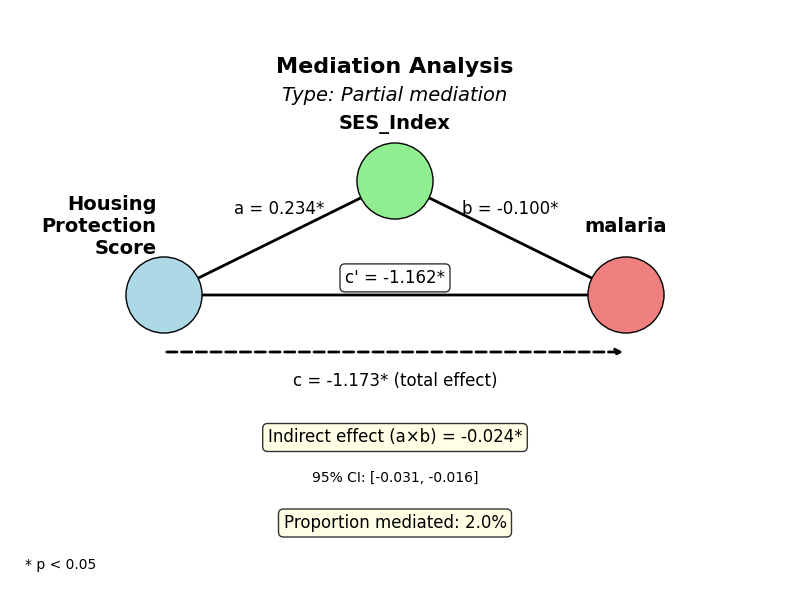


MEDIATION ANALYSIS SUMMARY REPORT
Independent variable (X): housing_protection_score
Mediator variable (M): SES_Index
Dependent variable (Y): malaria
Sample size: 30471
--------------------------------------------------

KEY FINDINGS:
1. Total effect of housing protection on malaria: OR = 0.309, p < 0.001
2. Effect of housing protection on SES: β = 0.234, p < 0.001
3. Effect of SES on malaria (controlling for housing): OR = 0.905, p < 0.001
4. Direct effect of housing on malaria (controlling for SES): OR = 0.313, p < 0.001
5. Indirect effect (through SES): -0.024, 95% CI [-0.031, -0.016]
6. Proportion of effect mediated: 2.0%
7. Mediation type: Partial mediation


In [74]:
# Run the full mediation analysis
print("\nRunning mediation analysis...")
results, path_diagram = perform_full_mediation_analysis(
    df_ses, 
    'housing_protection_score', 
    'SES_Index', 
    'malaria',
    n_bootstrap=5000
)

# Display the key findings
print("\nKEY FINDINGS:")

# 1. Total effect
odds_ratio = results['total_effect']['odds_ratio']
p_value = results['total_effect']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"1. Total effect of housing protection on malaria: OR = {odds_ratio:.3f}, {p_display}")

# 2. Path A effect
coef = results['path_a']['coefficient']
p_value = results['path_a']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"2. Effect of housing protection on SES: β = {coef:.3f}, {p_display}")

# 3. Path B effect
odds_ratio = results['path_b']['odds_ratio']
p_value = results['path_b']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"3. Effect of SES on malaria (controlling for housing): OR = {odds_ratio:.3f}, {p_display}")

# 4. Direct effect
odds_ratio = results['direct_effect']['odds_ratio']
p_value = results['direct_effect']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"4. Direct effect of housing on malaria (controlling for SES): OR = {odds_ratio:.3f}, {p_display}")

# 5-7. Remaining results (unchanged)
print(f"5. Indirect effect (through SES): {results['indirect_effect']['coefficient']:.3f}, 95% CI [{results['indirect_effect']['bootstrap_ci'][0]:.3f}, {results['indirect_effect']['bootstrap_ci'][1]:.3f}]")
print(f"6. Proportion of effect mediated: {results['proportion_mediated']:.1%}")
print(f"7. Mediation type: {results['mediation_type']}")